Projet - Analyse explo

In [1]:
# Chargement des librairies nécessaires
library(ggplot2)
library(tidyverse)
library(gridExtra)
library(GGally)
library(plotly)
library(corrplot)
library(reshape2)
library(FactoMineR) 
library(factoextra)
library(glmnet) 
library(ggfortify)
library(pROC)
library(ROCR)
library(repr)

Warning message:
"le package 'ggplot2' a été compilé avec la version R 4.3.3"
Warning message:
"le package 'tidyverse' a été compilé avec la version R 4.3.3"
Warning message:
"le package 'tibble' a été compilé avec la version R 4.3.3"
Warning message:
"le package 'tidyr' a été compilé avec la version R 4.3.3"
Warning message:
"le package 'readr' a été compilé avec la version R 4.3.3"
Warning message:
"le package 'purrr' a été compilé avec la version R 4.3.3"
Warning message:
"le package 'dplyr' a été compilé avec la version R 4.3.3"
Warning message:
"le package 'stringr' a été compilé avec la version R 4.3.3"
Warning message:
"le package 'forcats' a été compilé avec la version R 4.3.3"
Warning message:
"le package 'lubridate' a été compilé avec la version R 4.3.3"
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.4     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ 

In [2]:
options(repr.plot.width=15, repr.plot.height=8)


### Introduction

In [3]:
# Lecture des données
# path="http://www.math.univ-toulouse.fr/~besse/Wikistat/data/"
path <- ""
gym <- read.table(paste(path, "gym_members_exercise_tracking.csv", sep = ""),
                    sep = ",", header = TRUE)
# Premières lignes du jeu de données
head(gym)
# Vérification du contenu
summary(gym)

,Age,Gender,Weight..kg.,Height..m.,Max_BPM,Avg_BPM,Resting_BPM,Session_Duration..hours.,Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake..liters.,Workout_Frequency..days.week.,Experience_Level,BMI
,<int>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>
1,56,Male,88.3,1.71,180,157,60,1.69,1313,Yoga,12.6,3.5,4,3,30.20
2,46,Female,74.9,1.53,179,151,66,1.30,883,HIIT,33.9,2.1,4,2,32.00
3,32,Female,68.1,1.66,167,122,54,1.11,677,Cardio,33.4,2.3,4,2,24.71
4,25,Male,53.2,1.70,190,164,56,0.59,532,Strength,28.8,2.1,3,1,18.41
5,38,Male,46.1,1.79,188,158,68,0.64,556,Strength,29.2,2.8,3,1,14.39
6,56,Female,58.0,1.68,168,156,74,1.59,1116,HIIT,15.5,2.7,5,3,20.55


      Age           Gender           Weight..kg.       Height..m.   
 Min.   :18.00   Length:973         Min.   : 40.00   Min.   :1.500  
 1st Qu.:28.00   Class :character   1st Qu.: 58.10   1st Qu.:1.620  
 Median :40.00   Mode  :character   Median : 70.00   Median :1.710  
 Mean   :38.68                      Mean   : 73.85   Mean   :1.723  
 3rd Qu.:49.00                      3rd Qu.: 86.00   3rd Qu.:1.800  
 Max.   :59.00                      Max.   :129.90   Max.   :2.000  
    Max_BPM         Avg_BPM       Resting_BPM    Session_Duration..hours.
 Min.   :160.0   Min.   :120.0   Min.   :50.00   Min.   :0.500           
 1st Qu.:170.0   1st Qu.:131.0   1st Qu.:56.00   1st Qu.:1.040           
 Median :180.0   Median :143.0   Median :62.00   Median :1.260           
 Mean   :179.9   Mean   :143.8   Mean   :62.22   Mean   :1.256           
 3rd Qu.:190.0   3rd Qu.:156.0   3rd Qu.:68.00   3rd Qu.:1.460           
 Max.   :199.0   Max.   :169.0   Max.   :74.00   Max.   :2.000           

Ce jeu de données fournit un aperçu détaillé des routines d’exercice, des attributs physiques et des mesures
de la condition physique des membres d’une salle de sport. Il contient 15 variables observées chez 973 individus
fréquentant une salle de sport:
- Age : âge du membre de la salle de sport.
- Gender : Sexe du membre de la salle de sport (qualitative à deux modalités : homme ou femme).
- Weight..kg. : Poids du membre en kilogrammes.
- Height..m. : Taille du membre en mètres.
- Max_BPM : Fréquence cardiaque maximale (battements par minute) pendant les séances d’entraînement.
- Avg_BPM : Fréquence cardiaque moyenne pendant les séances d’entraînement.
- Resting_BPM : Fréquence cardiaque au repos avant l’entraînement.
- Session_Duration..hours. : Durée de chaque séance d’entraînement en heures.
- Calories_Burned : Total des calories brûlées au cours de chaque séance.
- Workout_Type : Type d’entraînement effectué (qualitative à 4 modalités : cardio, musculation, yoga,
HIIT).
- Fat_Percentage (Pourcentage de graisse) : Pourcentage de graisse corporelle du membre.
- Water_Intake..liters. : Consommation quotidienne d’eau pendant les séances d’entraînement.
- Workout_Frequency..days.week. : Nombre de séances d’entraînement par semaine (qualitative à 4
modalités : 2 à 5).
- Experience_Level : Niveau d’expérience (qualitative à 3 modalités : 1 pour débutant à 3 pour expert).
- BMI : Indice de masse corporelle (IMC), calculé à partir de la taille et du poids.

Dans ce projet, on souhaite dans un premier temps, prédire la variable Calories_Burned à partir de toutes
les autres variables, et dans un second temps, prédire la variable Experience_Level à partir de toutes les autres
variables (dont Calories_Burned).

In [4]:
gym[,'Gender'] <- as.factor(gym[,'Gender'])
gym[,'Workout_Type'] <- as.factor(gym[,'Workout_Type'])
gym[,'Experience_Level'] <- as.factor(gym[,'Experience_Level'])
gym[,'Workout_Frequency..days.week.'] <- as.factor(gym[,'Workout_Frequency..days.week.'])

In [5]:
summary(gym)

      Age           Gender     Weight..kg.       Height..m.       Max_BPM     
 Min.   :18.00   Female:462   Min.   : 40.00   Min.   :1.500   Min.   :160.0  
 1st Qu.:28.00   Male  :511   1st Qu.: 58.10   1st Qu.:1.620   1st Qu.:170.0  
 Median :40.00                Median : 70.00   Median :1.710   Median :180.0  
 Mean   :38.68                Mean   : 73.85   Mean   :1.723   Mean   :179.9  
 3rd Qu.:49.00                3rd Qu.: 86.00   3rd Qu.:1.800   3rd Qu.:190.0  
 Max.   :59.00                Max.   :129.90   Max.   :2.000   Max.   :199.0  
    Avg_BPM       Resting_BPM    Session_Duration..hours. Calories_Burned 
 Min.   :120.0   Min.   :50.00   Min.   :0.500            Min.   : 303.0  
 1st Qu.:131.0   1st Qu.:56.00   1st Qu.:1.040            1st Qu.: 720.0  
 Median :143.0   Median :62.00   Median :1.260            Median : 893.0  
 Mean   :143.8   Mean   :62.22   Mean   :1.256            Mean   : 905.4  
 3rd Qu.:156.0   3rd Qu.:68.00   3rd Qu.:1.460            3rd Qu.:1076.0

On distingue

11 variables quantitatives : Age, Weight, Height, Max_BPM, Avg_BPM, Resting_BPM, Session_duration, Calories Burned, Fat_Percentage, Water_Intake,BMI


4 variables qualitatives : Gender, Workout_Type, Workout_frequency, Experience_level

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


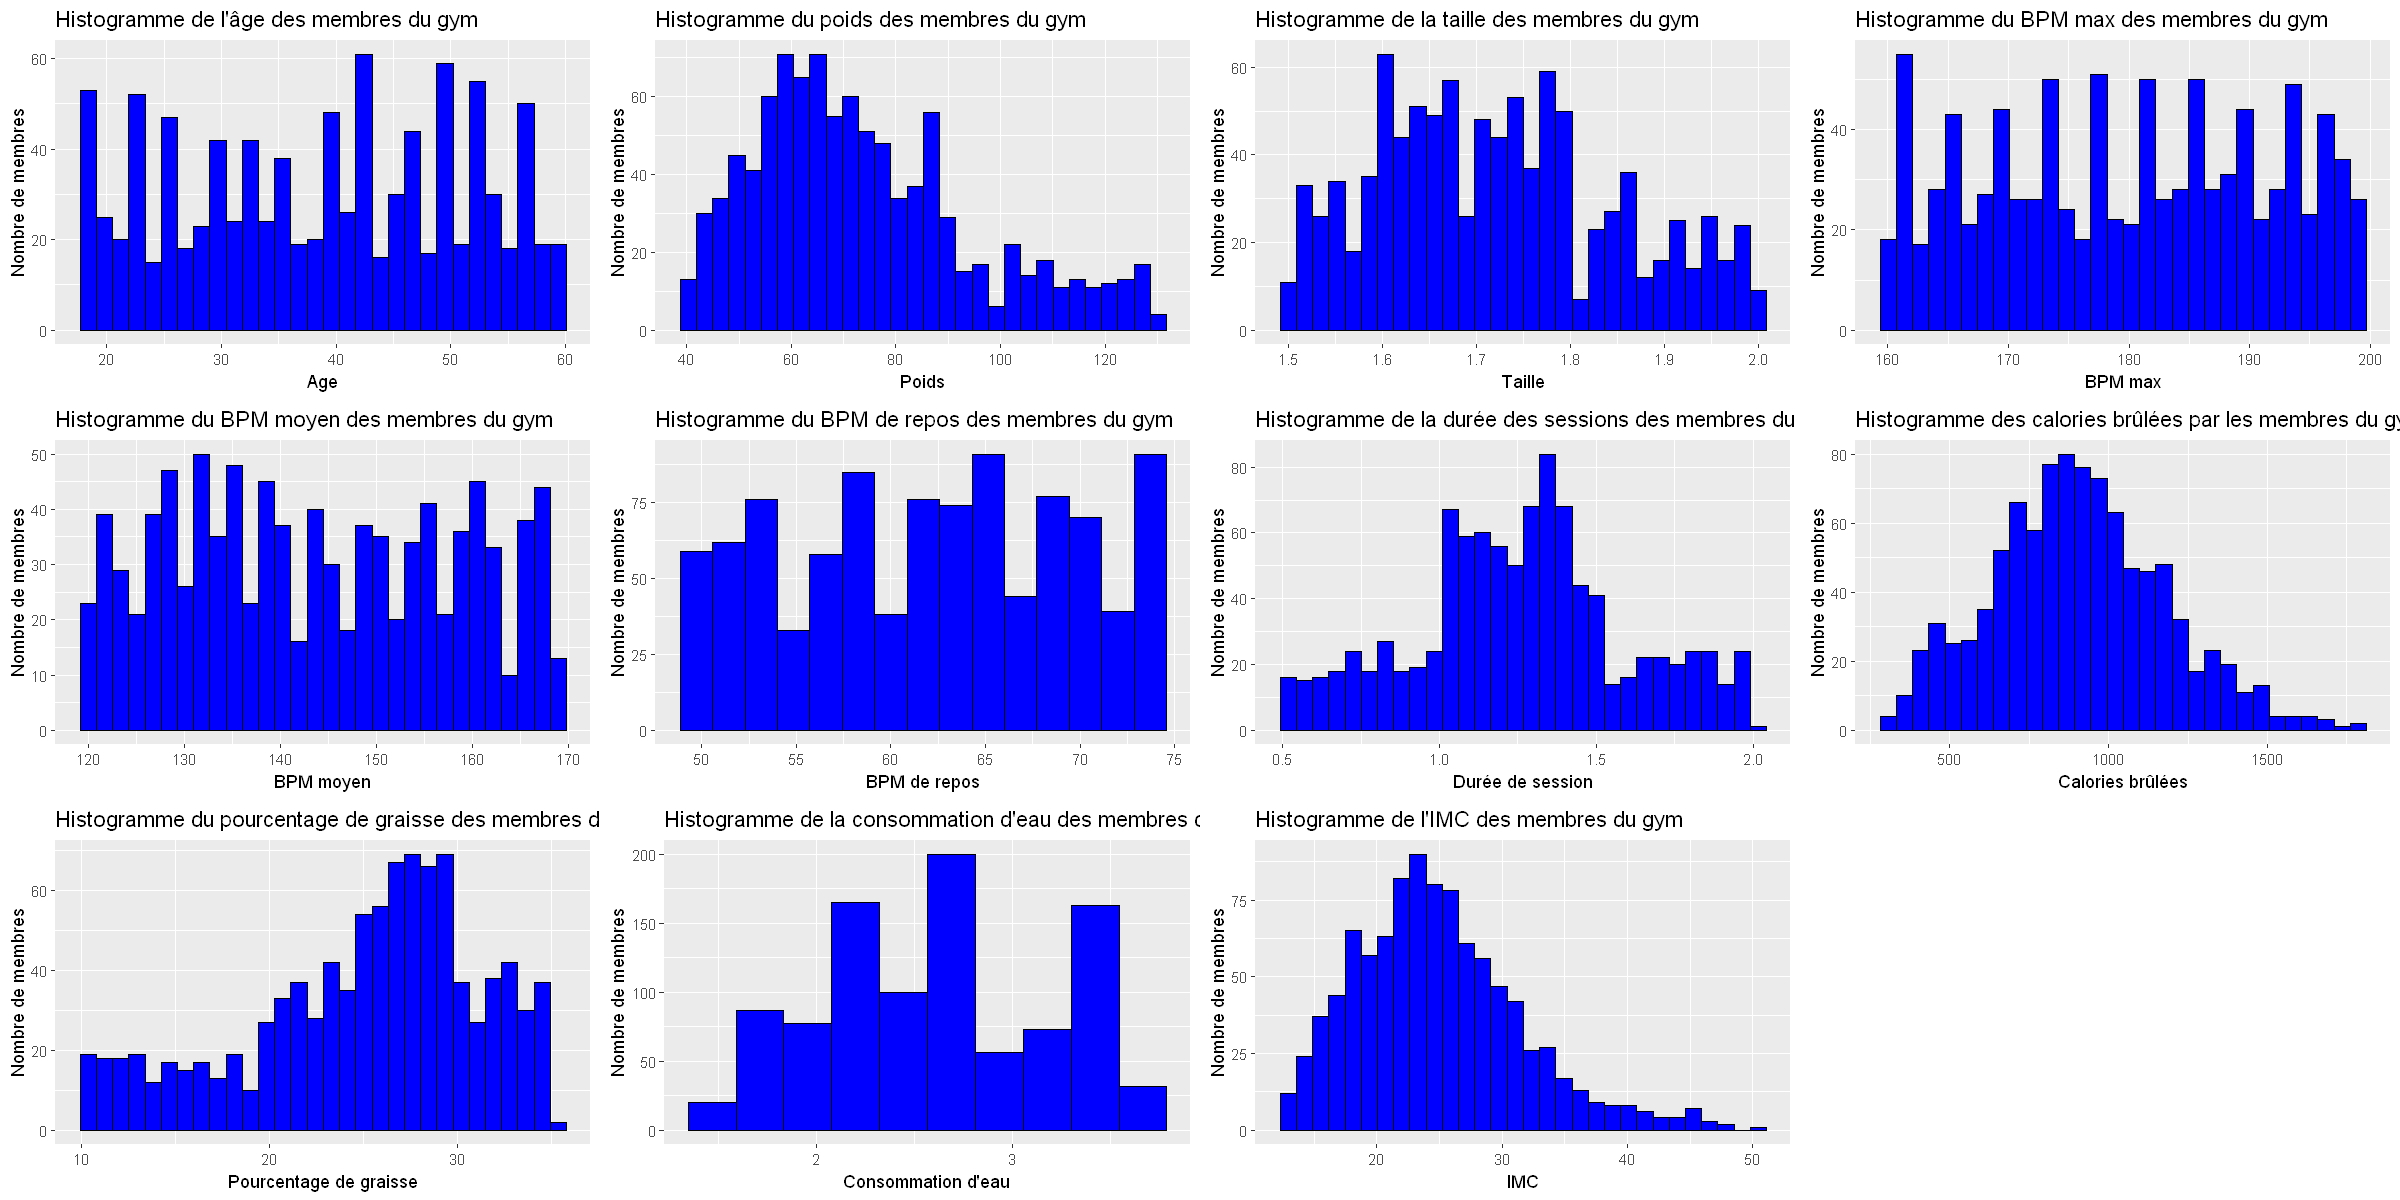

In [6]:
# Age	Gender	Weight..kg.	Height..m.	Max_BPM	Avg_BPM	Resting_BPM	Session_Duration..hours.	Calories_Burned	Workout_Type	Fat_Percentage	Water_Intake..liters.	Workout_Frequency..days.week.	Experience_Level	BMI
options(repr.plot.width=20, repr.plot.height=10)

g1<- ggplot(gym, aes(Age)) + geom_histogram( fill = "blue", color = "black") + labs(title = "Histogramme de l'âge des membres du gym", x = "Age", y = "Nombre de membres")
g2<- ggplot(gym, aes(Weight..kg.)) + geom_histogram( fill = "blue", color = "black") + labs(title = "Histogramme du poids des membres du gym", x = "Poids", y = "Nombre de membres")
g3<- ggplot(gym, aes(Height..m.)) + geom_histogram(fill = "blue", color = "black") + labs(title = "Histogramme de la taille des membres du gym", x = "Taille", y = "Nombre de membres")
g4 <- ggplot(gym, aes(Max_BPM)) + geom_histogram(fill = "blue", color = "black") + labs(title = "Histogramme du BPM max des membres du gym", x = "BPM max", y = "Nombre de membres")
g5 <- ggplot(gym, aes(Avg_BPM)) + geom_histogram(fill = "blue", color = "black") + labs(title = "Histogramme du BPM moyen des membres du gym", x = "BPM moyen", y = "Nombre de membres")
g6 <- ggplot(gym, aes(Resting_BPM)) + geom_histogram(bins=15, fill = "blue", color = "black") + labs(title = "Histogramme du BPM de repos des membres du gym", x = "BPM de repos", y = "Nombre de membres")
g7 <- ggplot(gym, aes(Session_Duration..hours.)) + geom_histogram( fill = "blue", color = "black") + labs(title = "Histogramme de la durée des sessions des membres du gym", x = "Durée de session", y = "Nombre de membres")
g8 <- ggplot(gym, aes(Calories_Burned)) + geom_histogram(fill = "blue", color = "black") + labs(title = "Histogramme des calories brûlées par les membres du gym", x = "Calories brûlées", y = "Nombre de membres")
g9 <- ggplot(gym, aes(Fat_Percentage)) + geom_histogram(fill = "blue", color = "black") + labs(title = "Histogramme du pourcentage de graisse des membres du gym", x = "Pourcentage de graisse", y = "Nombre de membres")
g10 <- ggplot(gym, aes(Water_Intake..liters.)) + geom_histogram(bins=10, fill = "blue", color = "black") + labs(title = "Histogramme de la consommation d'eau des membres du gym", x = "Consommation d'eau", y = "Nombre de membres")
g12 <- ggplot(gym, aes(BMI)) + geom_histogram( fill = "blue", color = "black") + labs(title = "Histogramme de l'IMC des membres du gym", x = "IMC", y = "Nombre de membres")

grid.arrange(g1, g2, g3, g4, g5, g6, g7, g8, g9, g10, g12, ncol = 4)
rm(g1, g2, g3, g4, g5, g6, g7, g8, g9, g10,  g12)

# Observations et Préparation des Données 


Les histogrammes montrent la distribution des différentes variables quantitatives dans le jeu de données.


En analysant les histogrammes, nous remarquons plusieurs points importants :  


- Certaines variables, comme **calories brulées, durée de session et consommation d'eau**, suivent une distribution normale.  
- D'autres variables, comme **IMC, poids et pourcentage de graisse**, présentent une forte asymétrie et devront être transformées.  
- Toutes les variales restantes présentent une trop grosse variabilités des valeurs pour être transformées

👉 **Conclusion** : Certaines variables présentent des écarts d'échelle importants, ce qui peut affecter nos analyses. Nous allons donc procéder à des transformations et normalisations dans la section suivante.  




## Transformation de variables

In [7]:
gym[, "SBMI"] <- sqrt(gym[,"BMI"])
gym[, "LBMI"] <- log(gym[,"BMI"])
gym[, "LWeight"] <- log(gym[,"Weight..kg."])
gym[, "SWeight"] <- sqrt(gym[,"Weight..kg."])

max_fat = max(gym[,"Fat_Percentage"])
gym[, "SFat_Percentage"] <- sqrt((max_fat + 1) - gym[,"Fat_Percentage"])
gym[, "LFat_Percentage"] <- log((max_fat + 1) - gym[,"Fat_Percentage"])

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


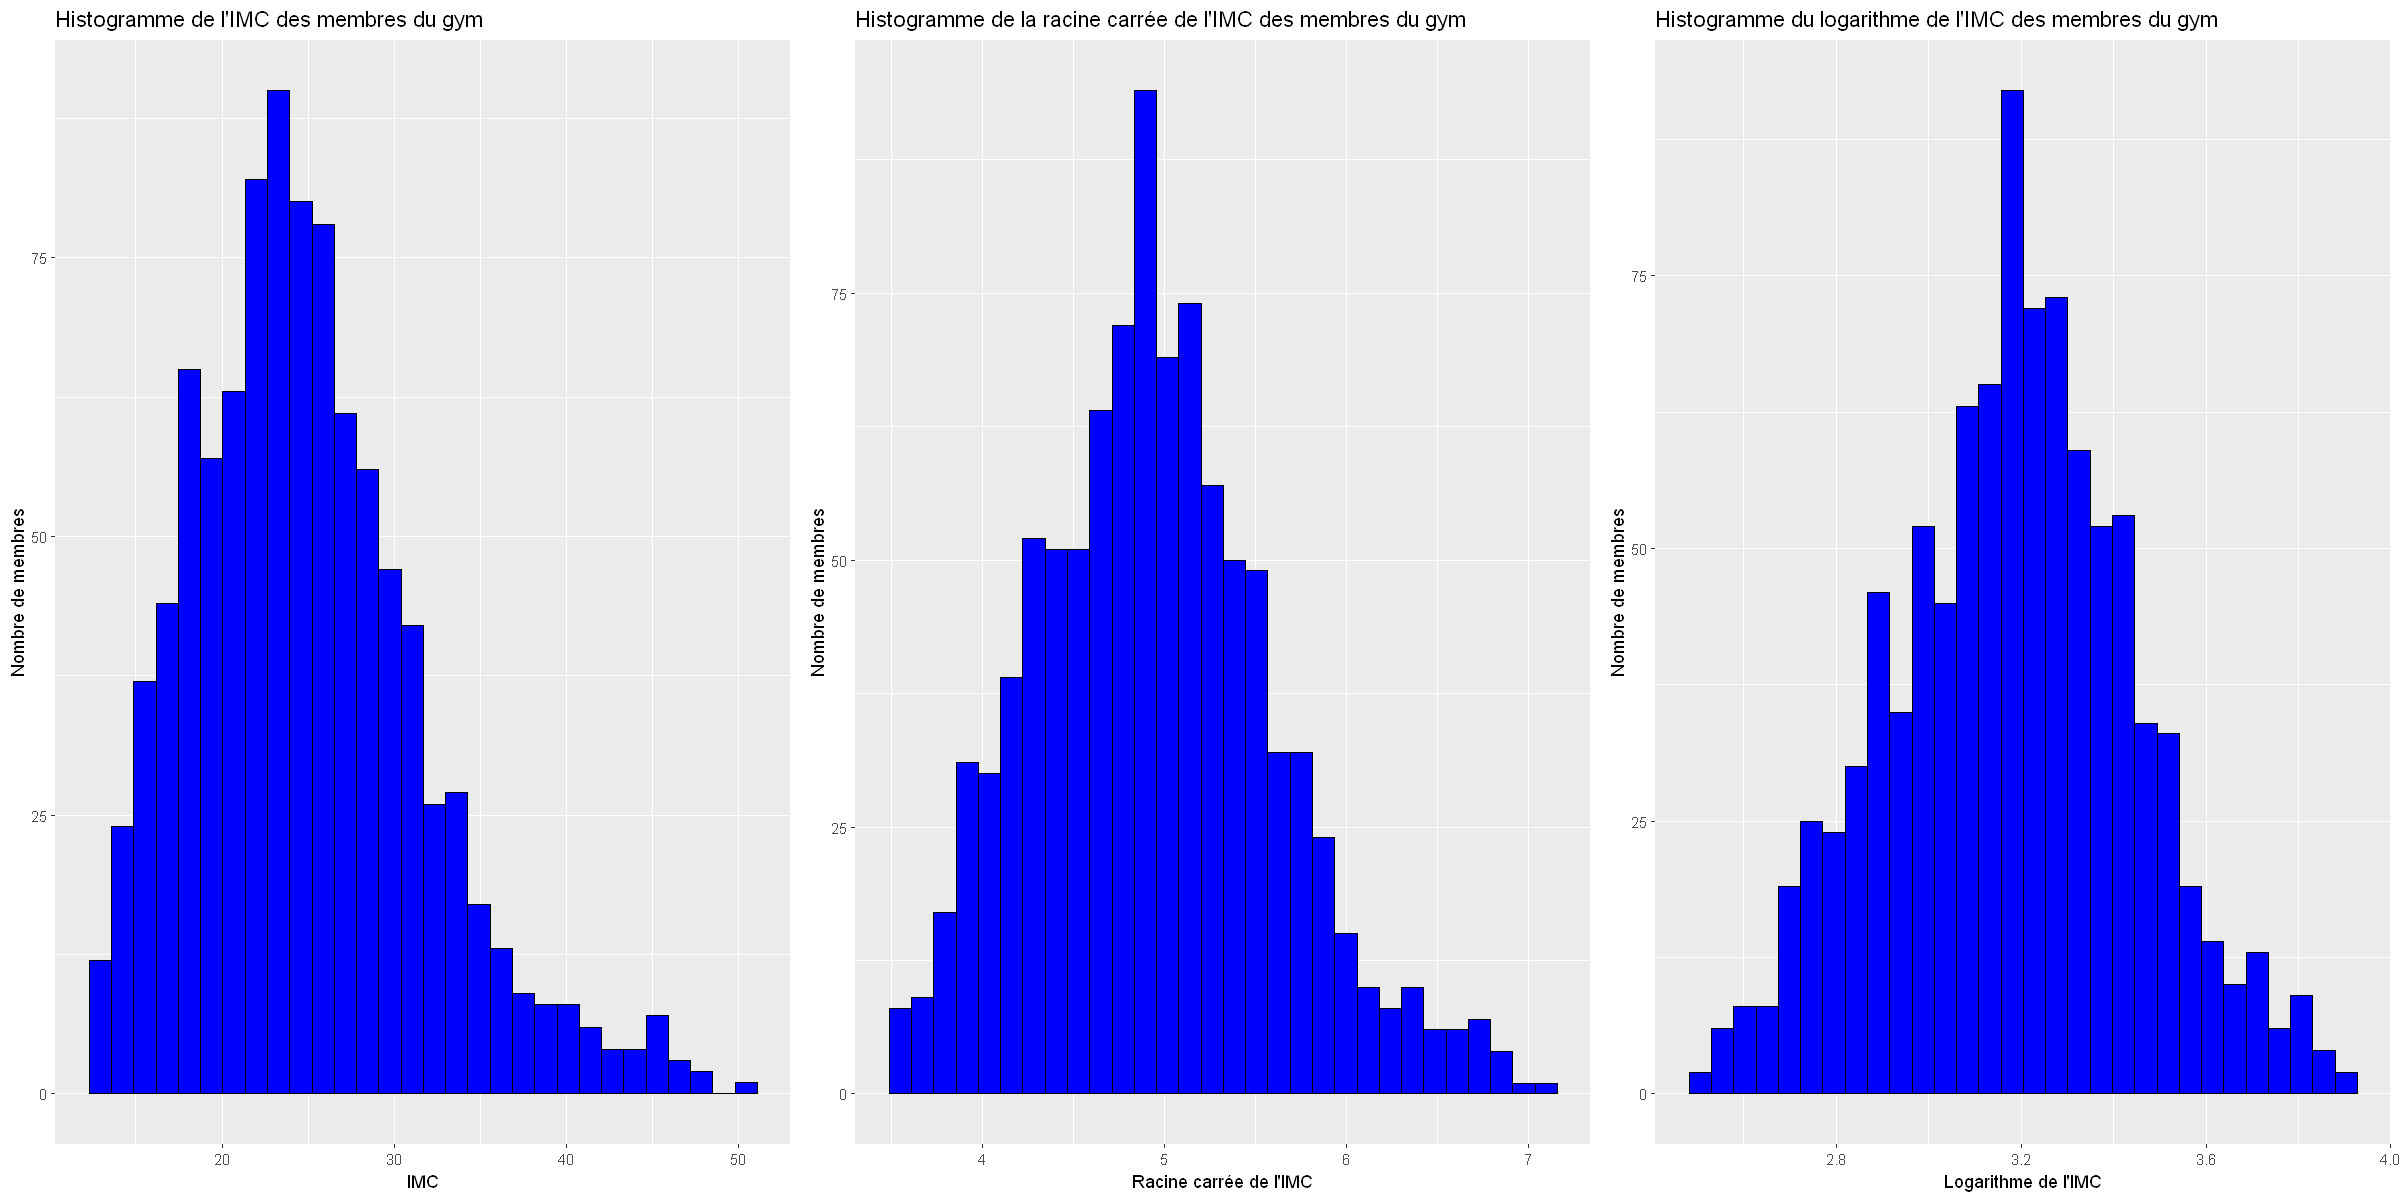

In [8]:
# Tracer les histogrammes de IMC Weight..kg. Fat_Percentage et les transformations
options(repr.plot.width=20, repr.plot.height=10)
g1 <- ggplot(gym, aes(BMI)) + geom_histogram(fill = "blue", color = "black") + labs(title = "Histogramme de l'IMC des membres du gym", x = "IMC", y = "Nombre de membres")
g2 <- ggplot(gym, aes(SBMI)) + geom_histogram(fill = "blue", color = "black") + labs(title = "Histogramme de la racine carrée de l'IMC des membres du gym", x = "Racine carrée de l'IMC", y = "Nombre de membres")
g3 <- ggplot(gym, aes(LBMI)) + geom_histogram(fill = "blue", color = "black") + labs(title = "Histogramme du logarithme de l'IMC des membres du gym", x = "Logarithme de l'IMC", y = "Nombre de membres")



grid.arrange(g1, g2, g3, ncol = 3)
rm(g1, g2, g3)


Suite à ces transformations, nous observons que la troisième transformation, qui consiste à appliquer le logarithme à l'IMC, est celle que nous allons retenir, car elle présente la distribution la plus proche de la normale.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


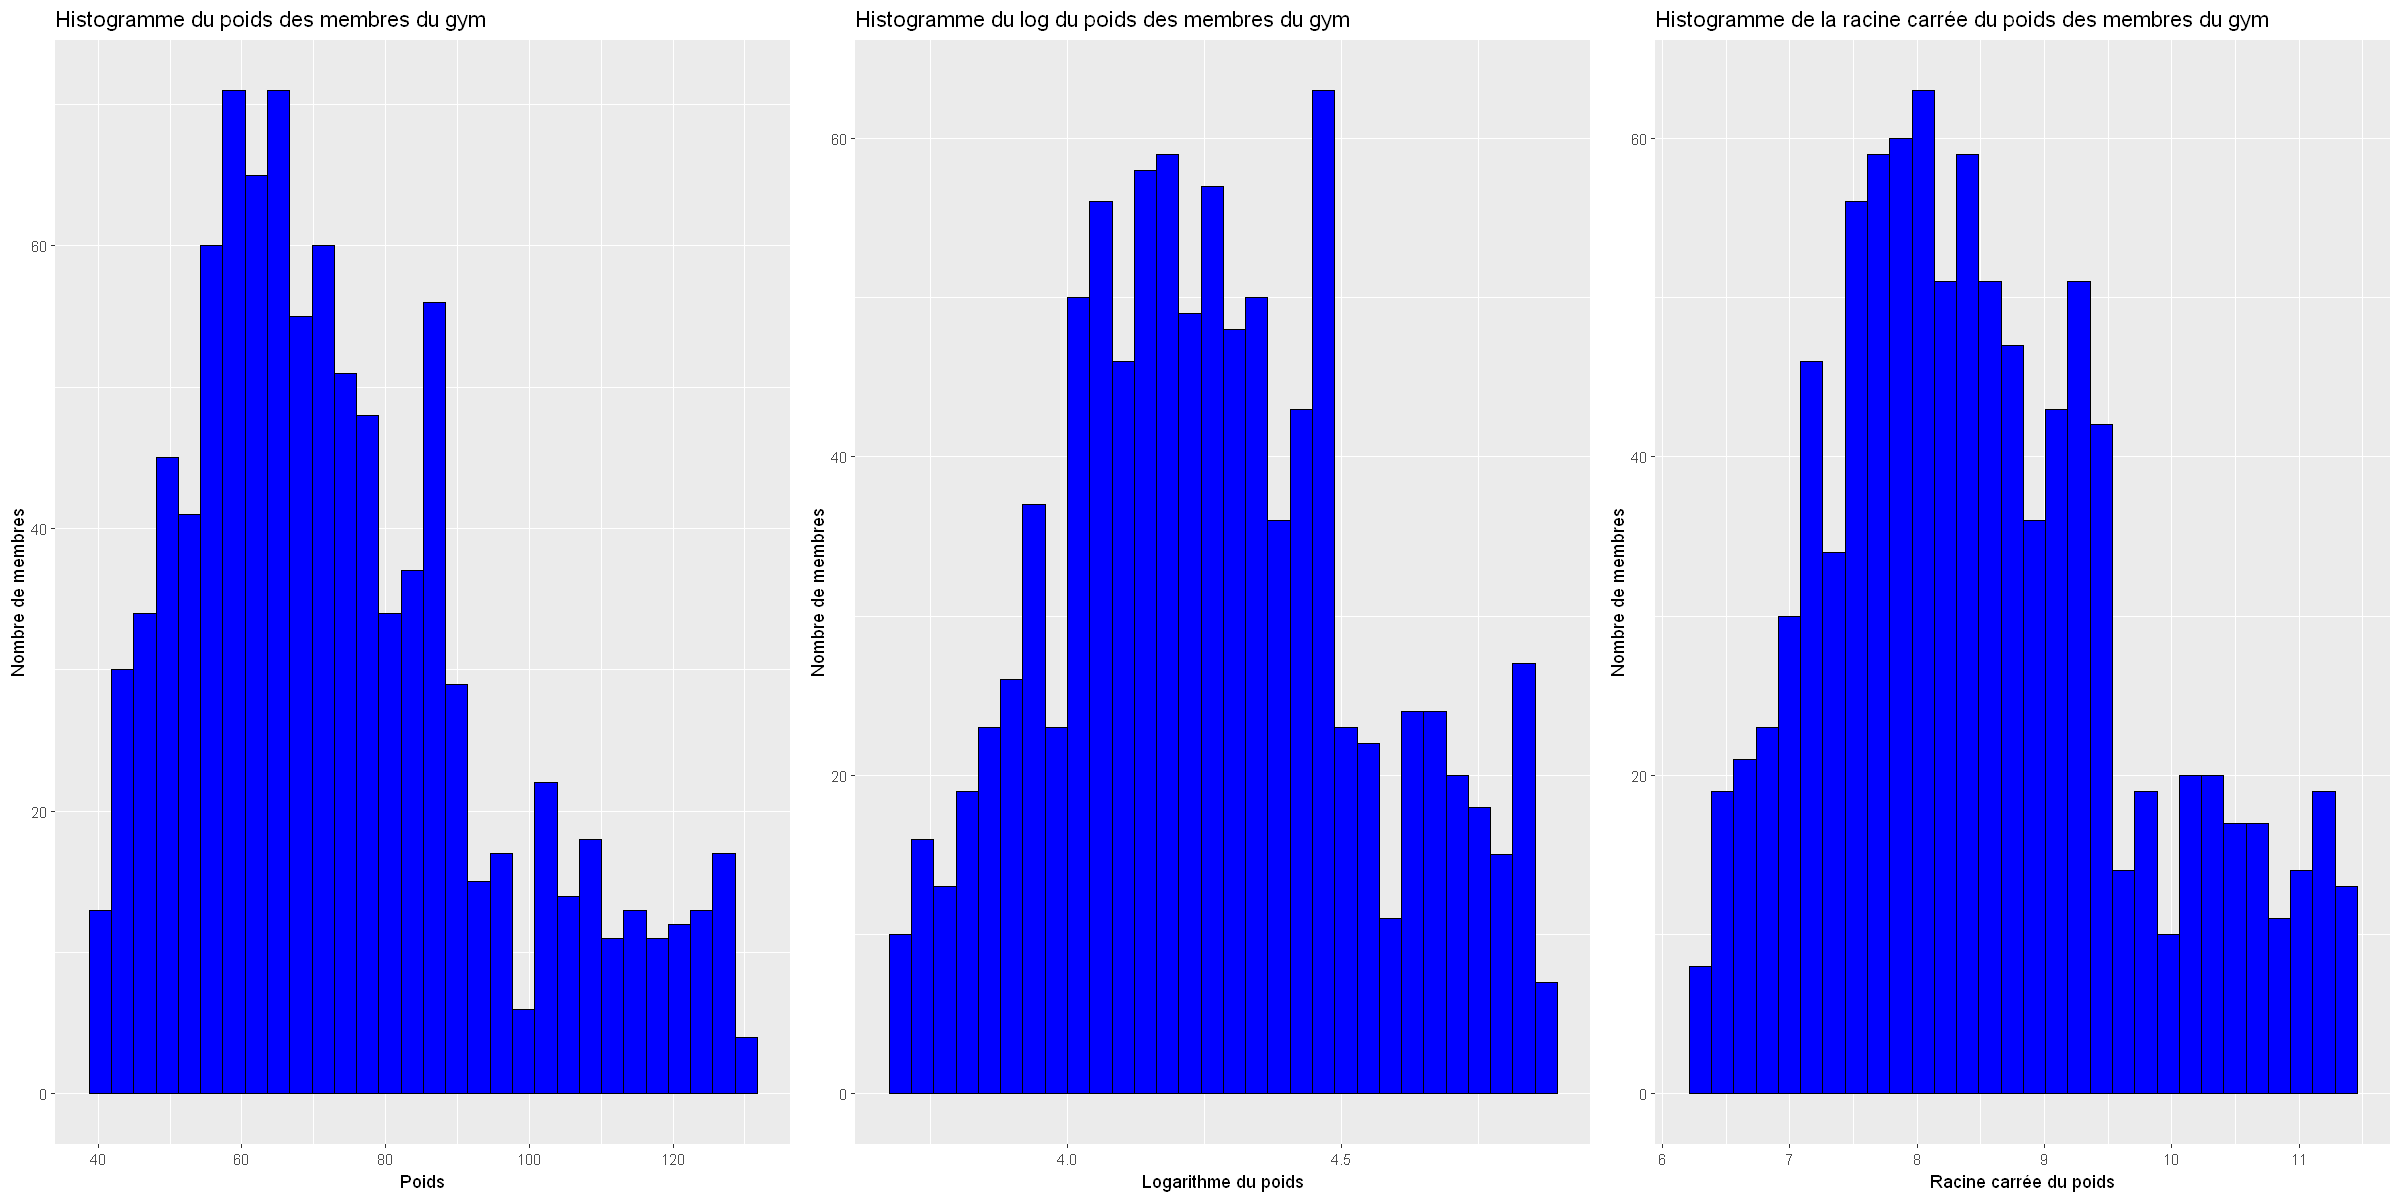

In [9]:
g4 <- ggplot(gym, aes(Weight..kg.)) + geom_histogram(fill = "blue", color = "black") + labs(title = "Histogramme du poids des membres du gym", x = "Poids", y = "Nombre de membres")
g5 <- ggplot(gym, aes(LWeight)) + geom_histogram(fill = "blue", color = "black") + labs(title = "Histogramme du log du poids des membres du gym", x = "Logarithme du poids", y = "Nombre de membres")
g6 <- ggplot(gym, aes(SWeight)) + geom_histogram(fill = "blue", color = "black") + labs(title = "Histogramme de la racine carrée du poids des membres du gym", x = "Racine carrée du poids", y = "Nombre de membres")
grid.arrange(g4, g5,g6, ncol = 3)
rm(g4, g5, g6)


Suite à ces transformations, nous observons que la deuxième transformation, qui consiste à appliquer le logarithme à l'IMC, est celle que nous allons retenir, car elle présente la distribution la plus proche de la normale.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


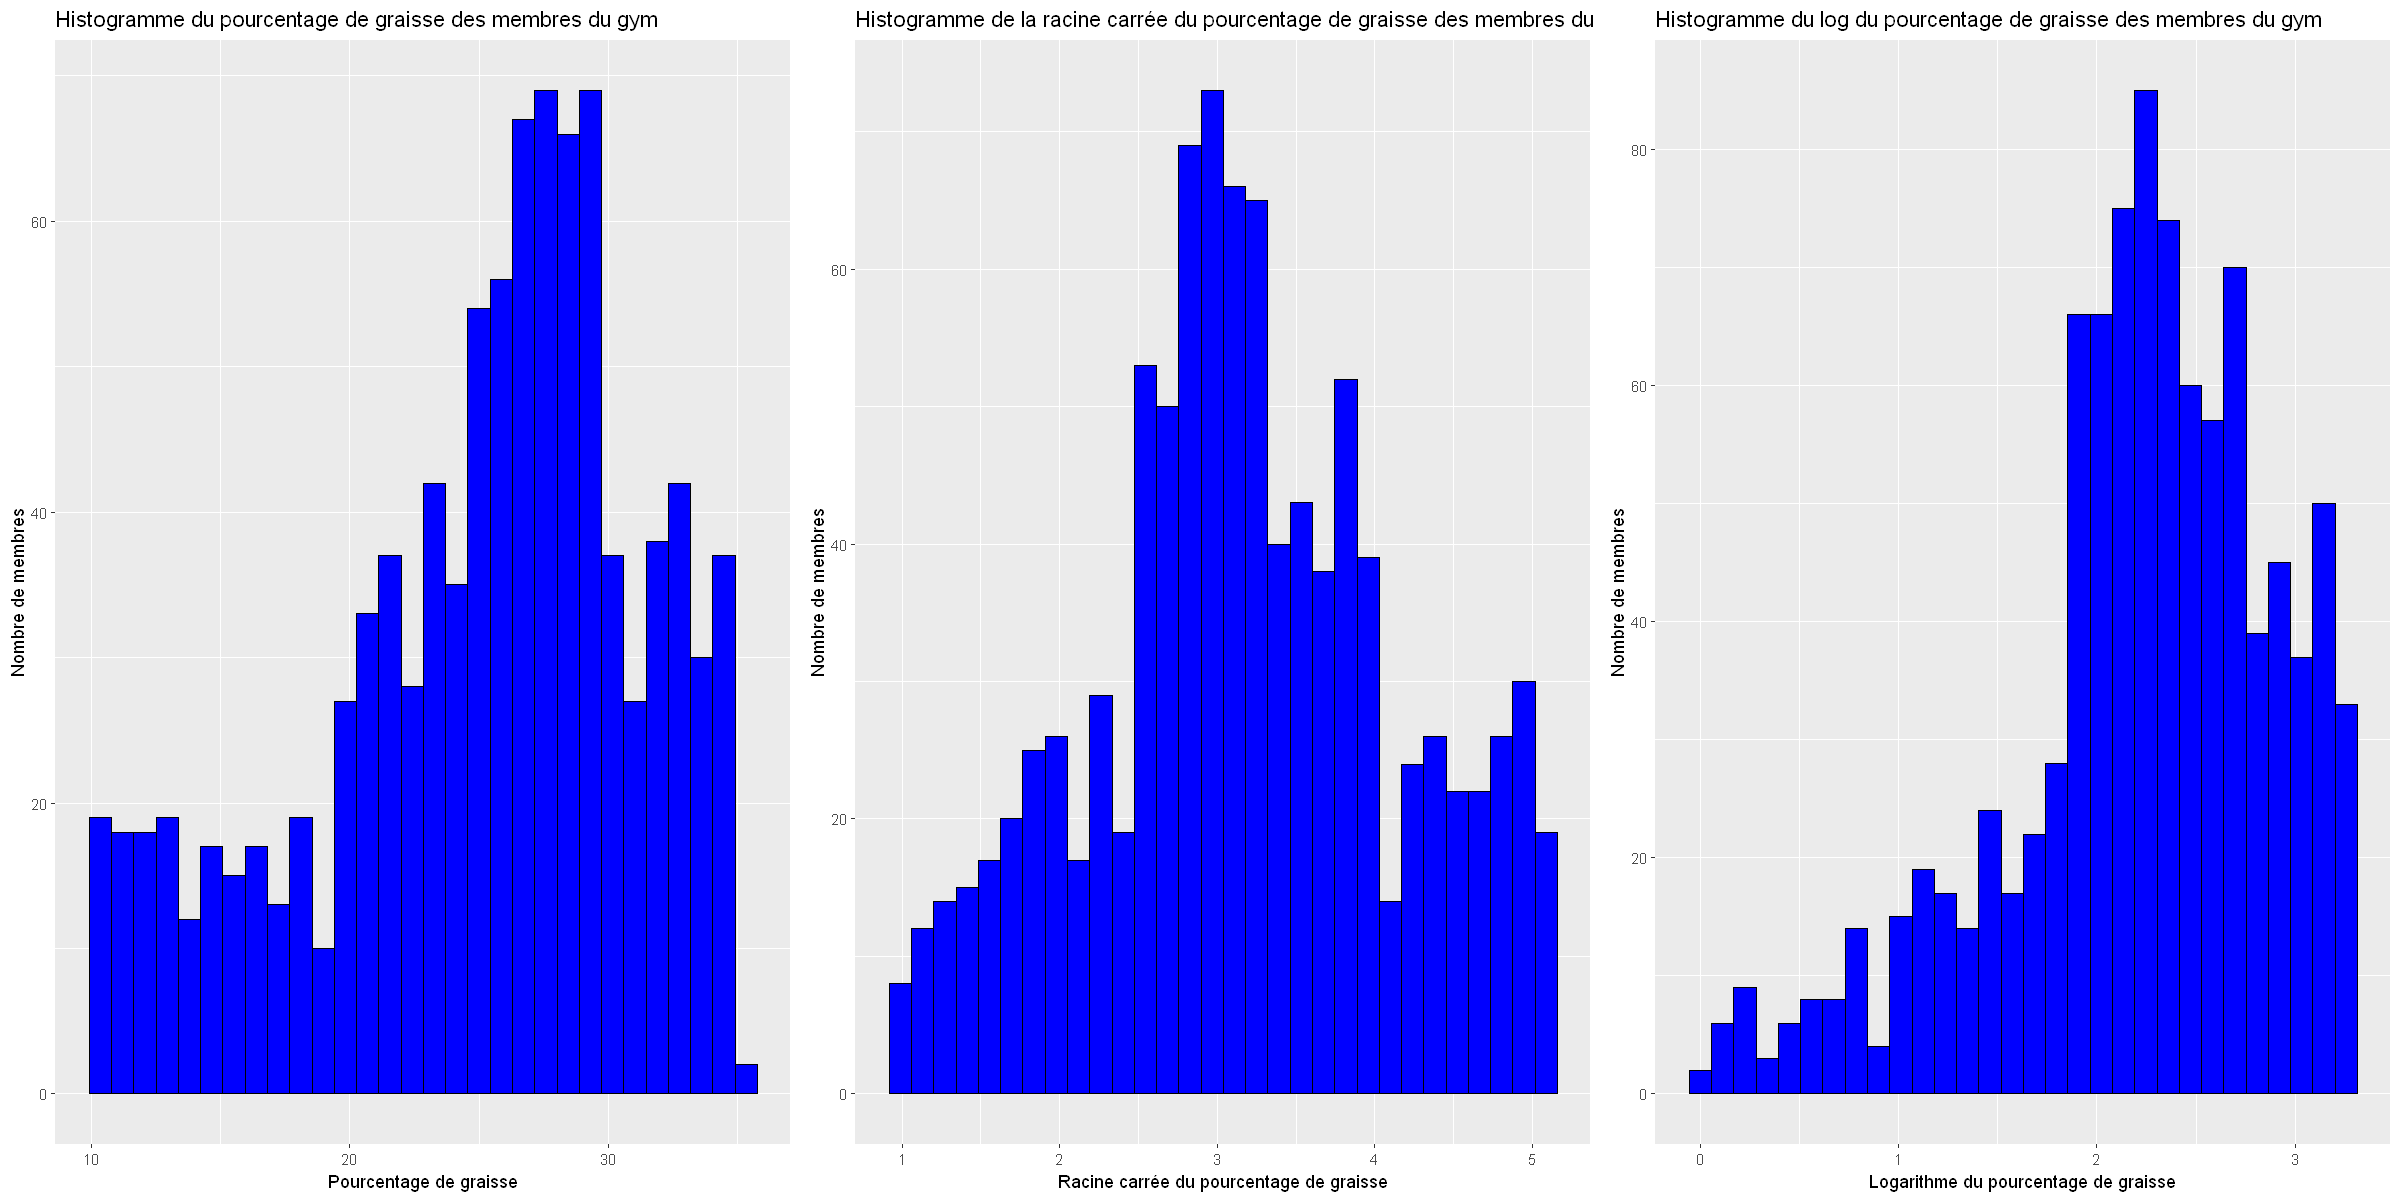

In [10]:
g7 <- ggplot(gym, aes(Fat_Percentage)) + geom_histogram(fill = "blue", color = "black") + labs(title = "Histogramme du pourcentage de graisse des membres du gym", x = "Pourcentage de graisse", y = "Nombre de membres")
g8 <- ggplot(gym, aes(SFat_Percentage)) + geom_histogram(fill = "blue", color = "black") + labs(title = "Histogramme de la racine carrée du pourcentage de graisse des membres du gym", x = "Racine carrée du pourcentage de graisse", y = "Nombre de membres")
g9 <- ggplot(gym, aes(LFat_Percentage)) + geom_histogram(fill = "blue", color = "black") + labs(title = "Histogramme du log du pourcentage de graisse des membres du gym", x = "Logarithme du pourcentage de graisse", y = "Nombre de membres")
grid.arrange(g7, g8, g9, ncol = 3)
rm(g7, g8, g9)

Suite à ces transformations, nous observons que la deuxième transformation, qui consiste à appliquer la racine carrée de Fat_Percentage, est celle que nous allons retenir, car elle présente la distribution la plus proche de la normale.

In [11]:
gym[, "Weight..kg."] <- log(gym[,"Weight..kg."])
gym[, "BMI"] <- log(gym[,"BMI"])

max_fat <- max(gym[,"Fat_Percentage"])
gym[, "Fat_Percentage"] <- sqrt((max_fat + 1) - gym[,"Fat_Percentage"])

# renome les variables Weight..kg. et BMI en LWeight et LBMI
names(gym)[names(gym) == "Weight..kg."] <- "LWeight"
names(gym)[names(gym) == "BMI"] <- "LBMI"
names(gym)[names(gym) == "Fat_Percentage"] <- "SFat_Percentage"

# supprimer les colonnes 16 à 21
gym <- gym[, -c(16:21)]

In [12]:
summary(gym)

      Age           Gender       LWeight        Height..m.       Max_BPM     
 Min.   :18.00   Female:462   Min.   :3.689   Min.   :1.500   Min.   :160.0  
 1st Qu.:28.00   Male  :511   1st Qu.:4.062   1st Qu.:1.620   1st Qu.:170.0  
 Median :40.00                Median :4.248   Median :1.710   Median :180.0  
 Mean   :38.68                Mean   :4.263   Mean   :1.723   Mean   :179.9  
 3rd Qu.:49.00                3rd Qu.:4.454   3rd Qu.:1.800   3rd Qu.:190.0  
 Max.   :59.00                Max.   :4.867   Max.   :2.000   Max.   :199.0  
    Avg_BPM       Resting_BPM    Session_Duration..hours. Calories_Burned 
 Min.   :120.0   Min.   :50.00   Min.   :0.500            Min.   : 303.0  
 1st Qu.:131.0   1st Qu.:56.00   1st Qu.:1.040            1st Qu.: 720.0  
 Median :143.0   Median :62.00   Median :1.260            Median : 893.0  
 Mean   :143.8   Mean   :62.22   Mean   :1.256            Mean   : 905.4  
 3rd Qu.:156.0   3rd Qu.:68.00   3rd Qu.:1.460            3rd Qu.:1076.0  
 Max

## Variables qualitatives

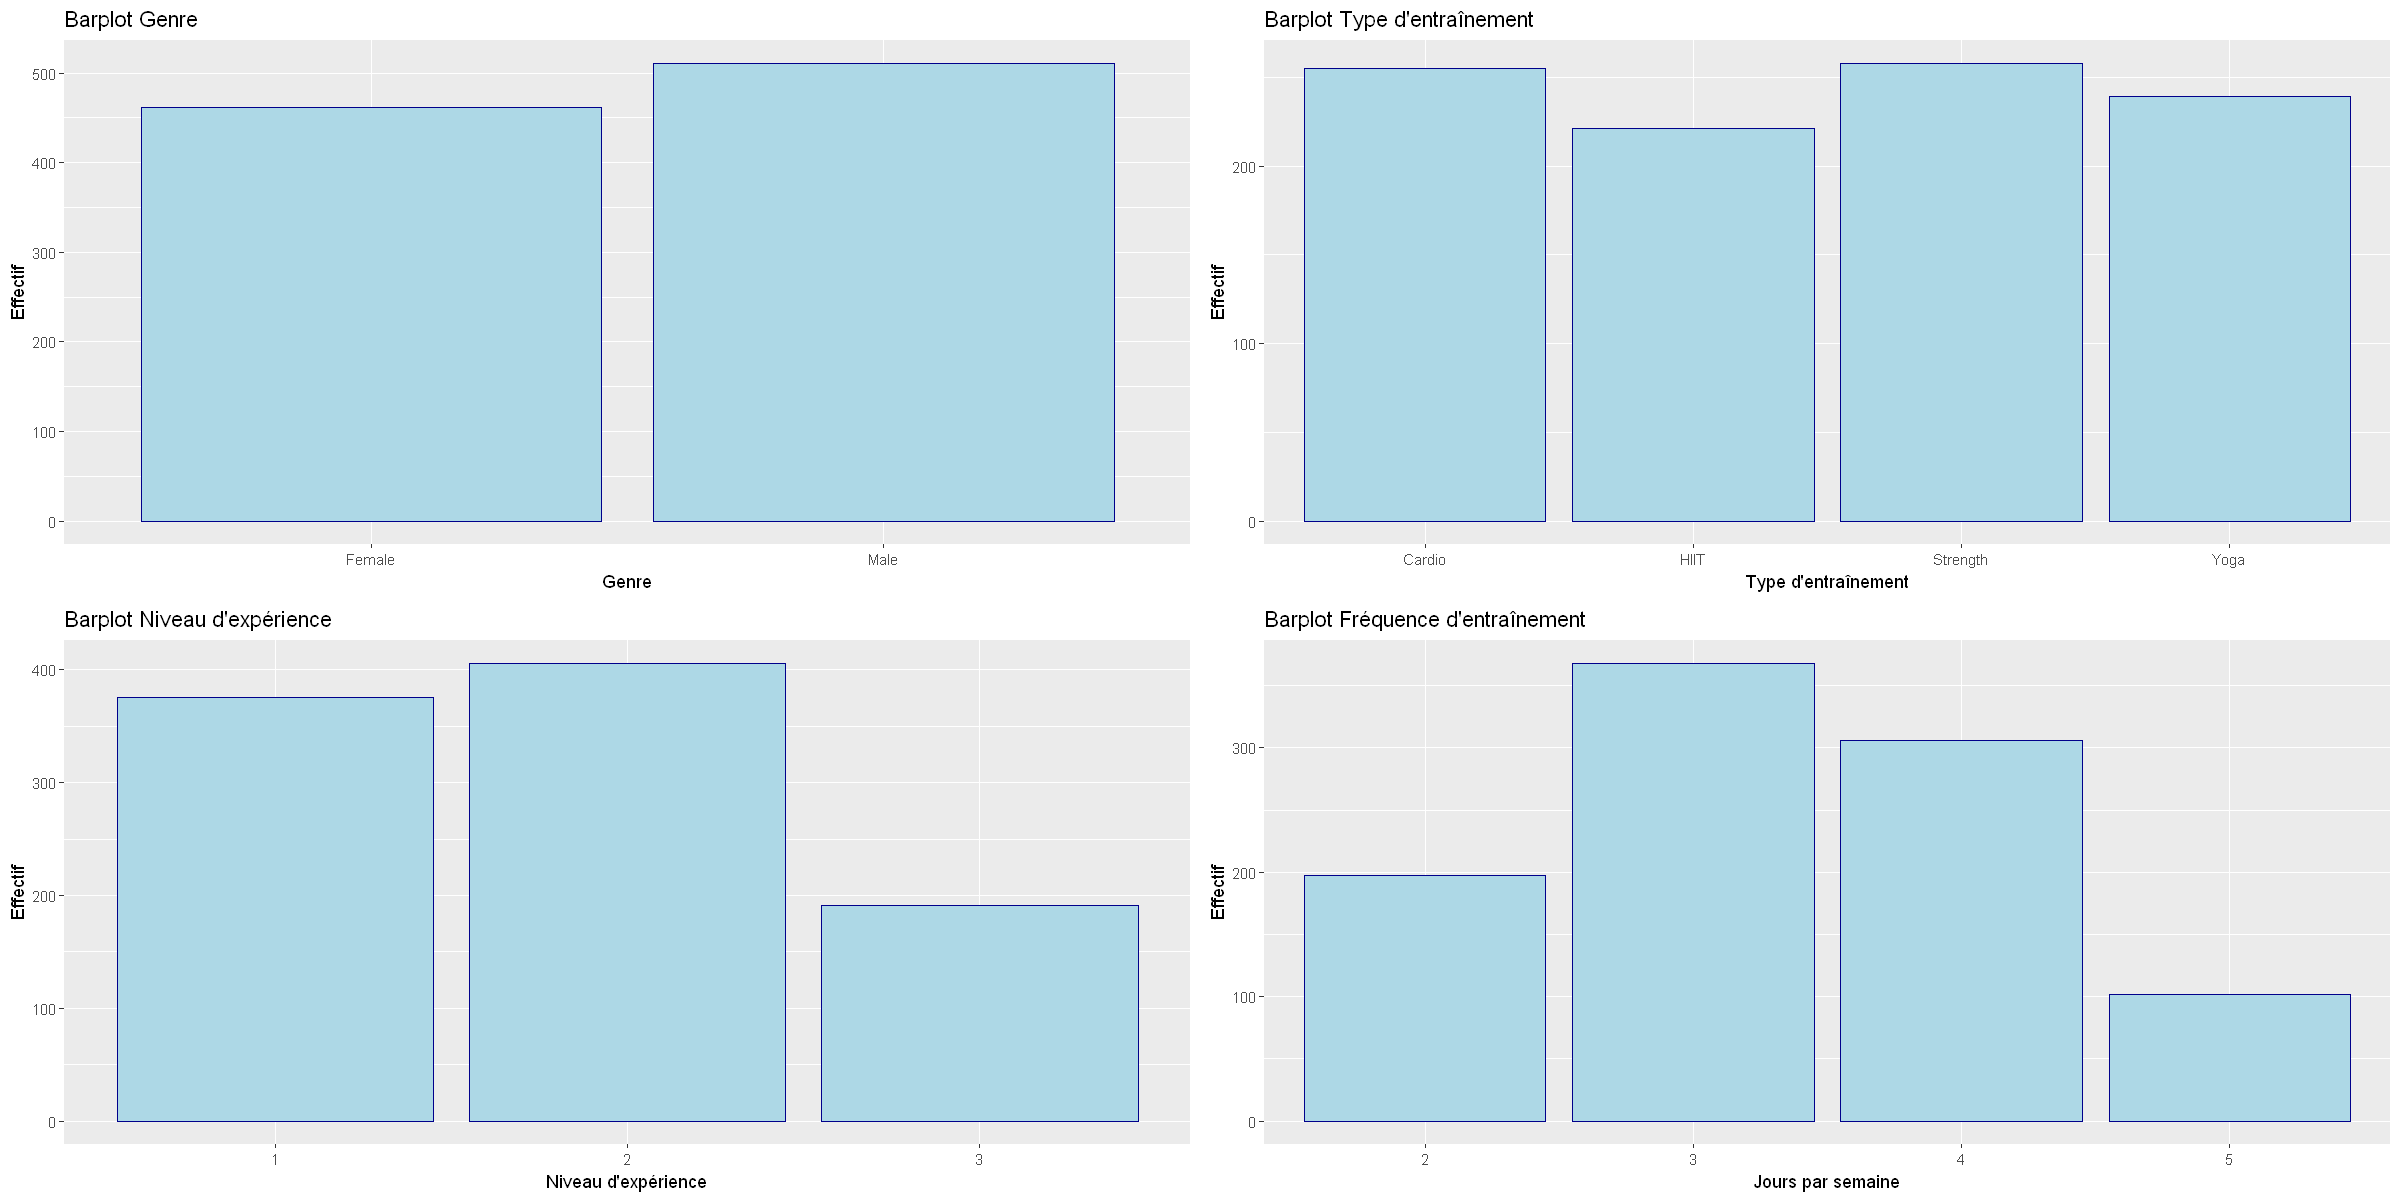

In [13]:
# Générer des barplots pour les variables qualitatives
q1 <- ggplot(gym, aes(x = Gender)) +
    geom_bar(fill = "lightblue", color = "darkblue") +
    labs(title = "Barplot Genre", x = "Genre", y = "Effectif")

q2 <- ggplot(gym, aes(x = Workout_Type)) +
    geom_bar(fill = "lightblue", color = "darkblue") +
    labs(title = "Barplot Type d'entraînement", x = "Type d'entraînement", y = "Effectif")

q3 <- ggplot(gym, aes(x = Experience_Level)) +
    geom_bar(fill = "lightblue", color = "darkblue") +
    labs(title = "Barplot Niveau d'expérience", x = "Niveau d'expérience", y = "Effectif")

q4 <- ggplot(gym, aes(x = Workout_Frequency..days.week.)) +
    geom_bar(fill = "lightblue", color = "darkblue") +
    labs(title = "Barplot Fréquence d'entraînement", x = "Jours par semaine", y = "Effectif")

grid.arrange(q1, q2, q3, q4, ncol = 2)

rm(q1, q2, q3, q4)


# Les barplots illustrent la répartition des variables qualitatives comme suit :
1. **Genre** : Il y a davantage d'hommes que de femmes dans la salle de sport.
2. **Workout_Type** :  Les types d'entraînement sont divers, mais assez homogènes dans leur répartition
3. **Experience_Level** : La majorité des membres sont classés comme débutants ou intermédiaires.
4. **Workout_Frequency**: La fréquence varie, mais on observe une concentration autour de 3 à 5 jours d'entraînement par semaine.


Les mosaic plots montrent les relations entre les variables qualitatives :


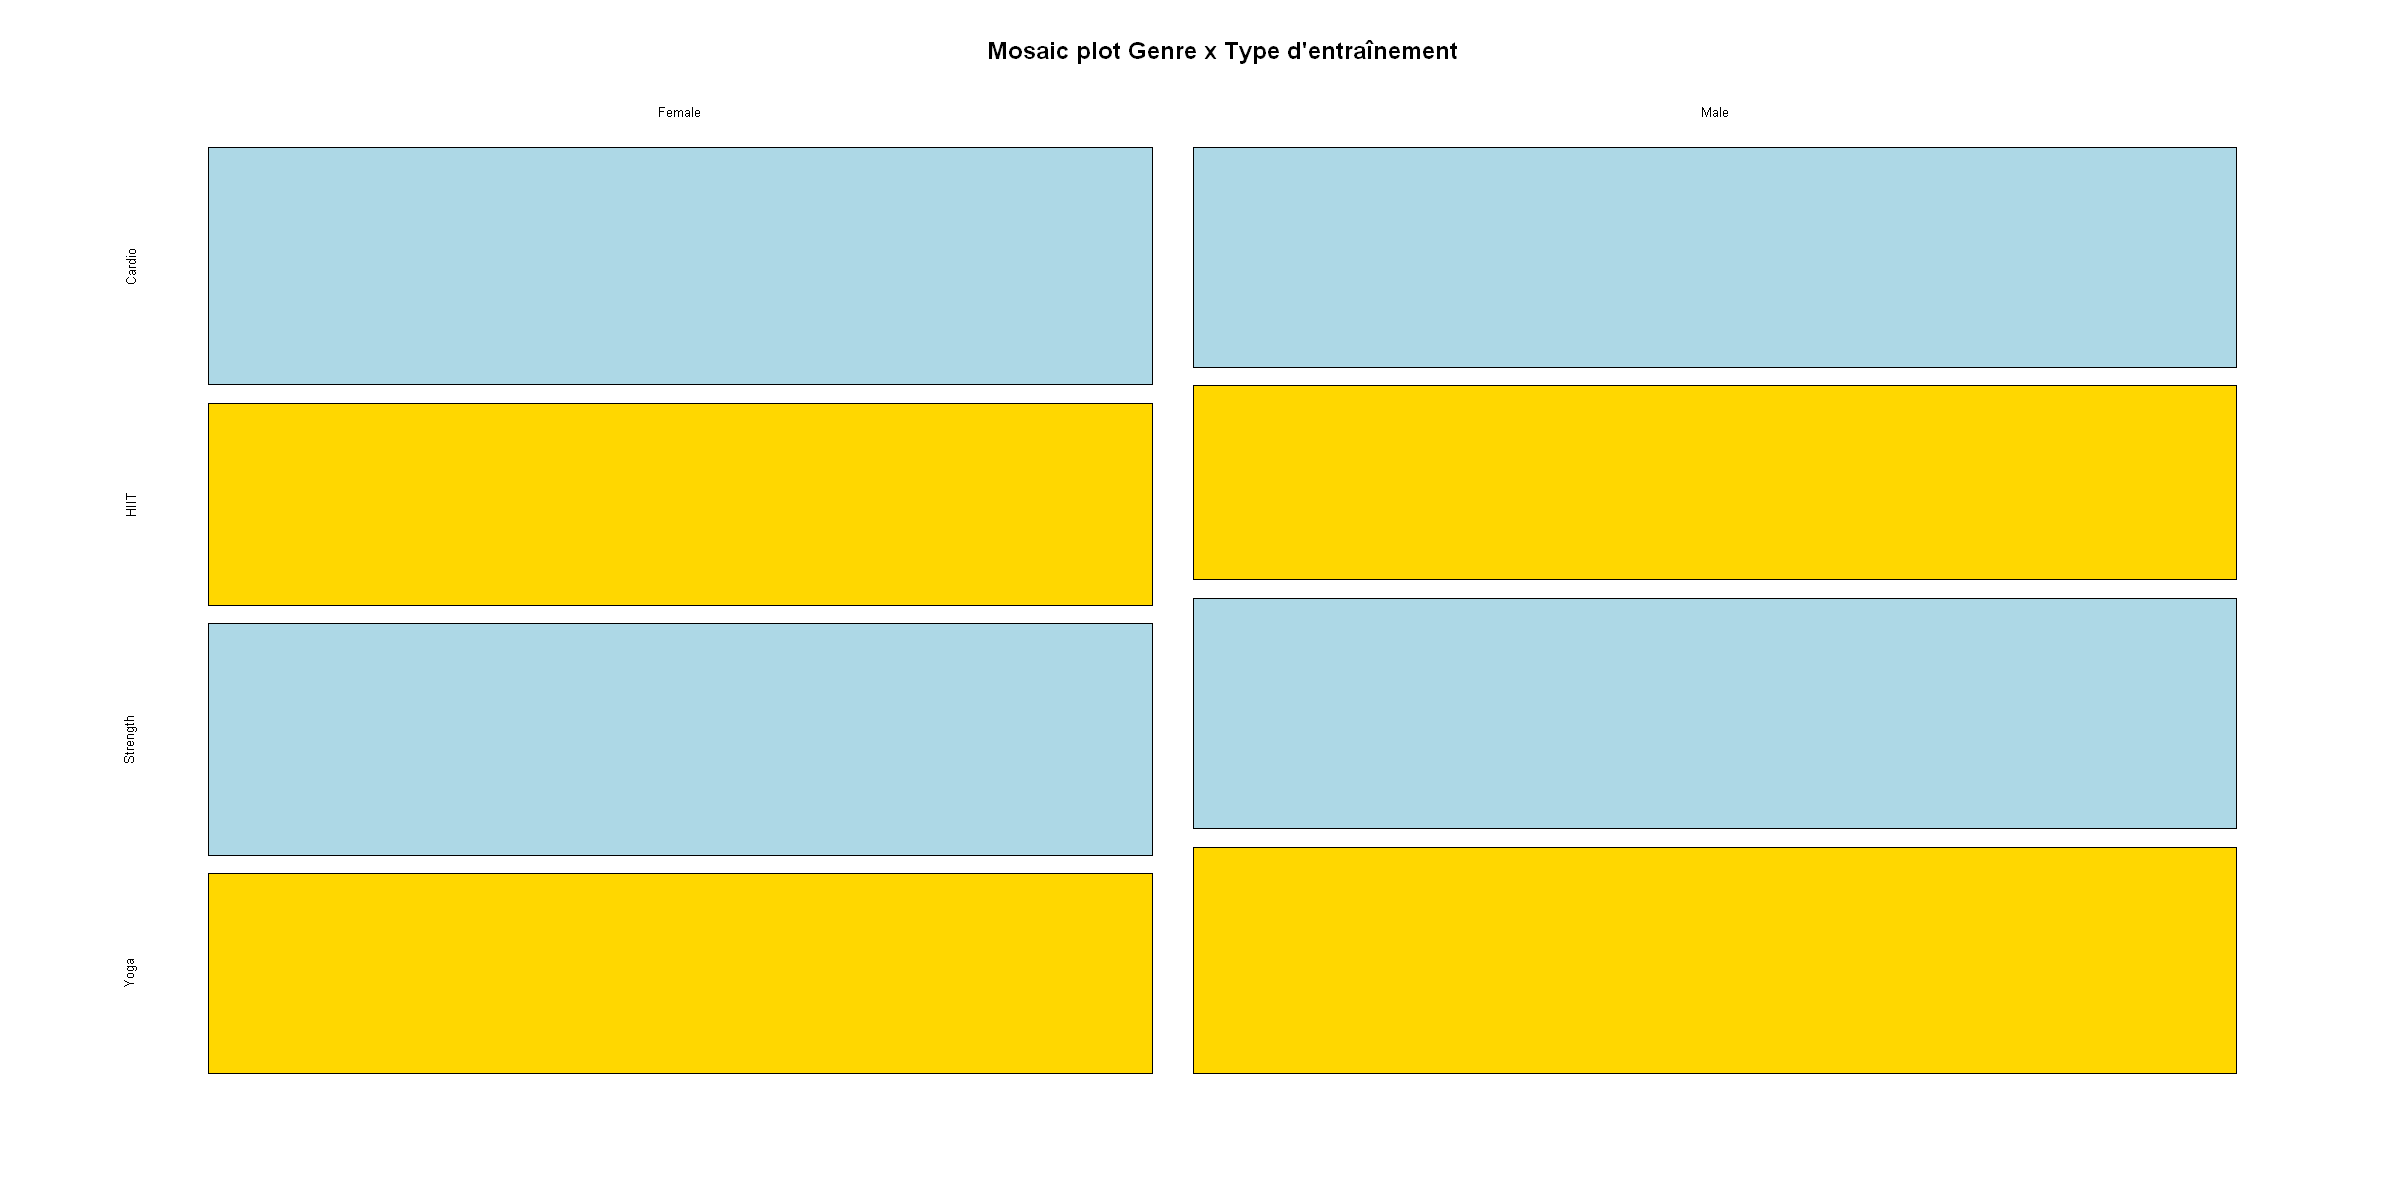

In [14]:
# Générer des mosaic plot pour les variables qualitatives

mosaicplot(table(gym$Gender, gym$Workout_Type), main = "Mosaic plot Genre x Type d'entraînement", color = c("lightblue", "gold"))


Genre x Type d'entraînement : Les hommes et les femmes ont des préférences similaires pour les types d'entraînement.


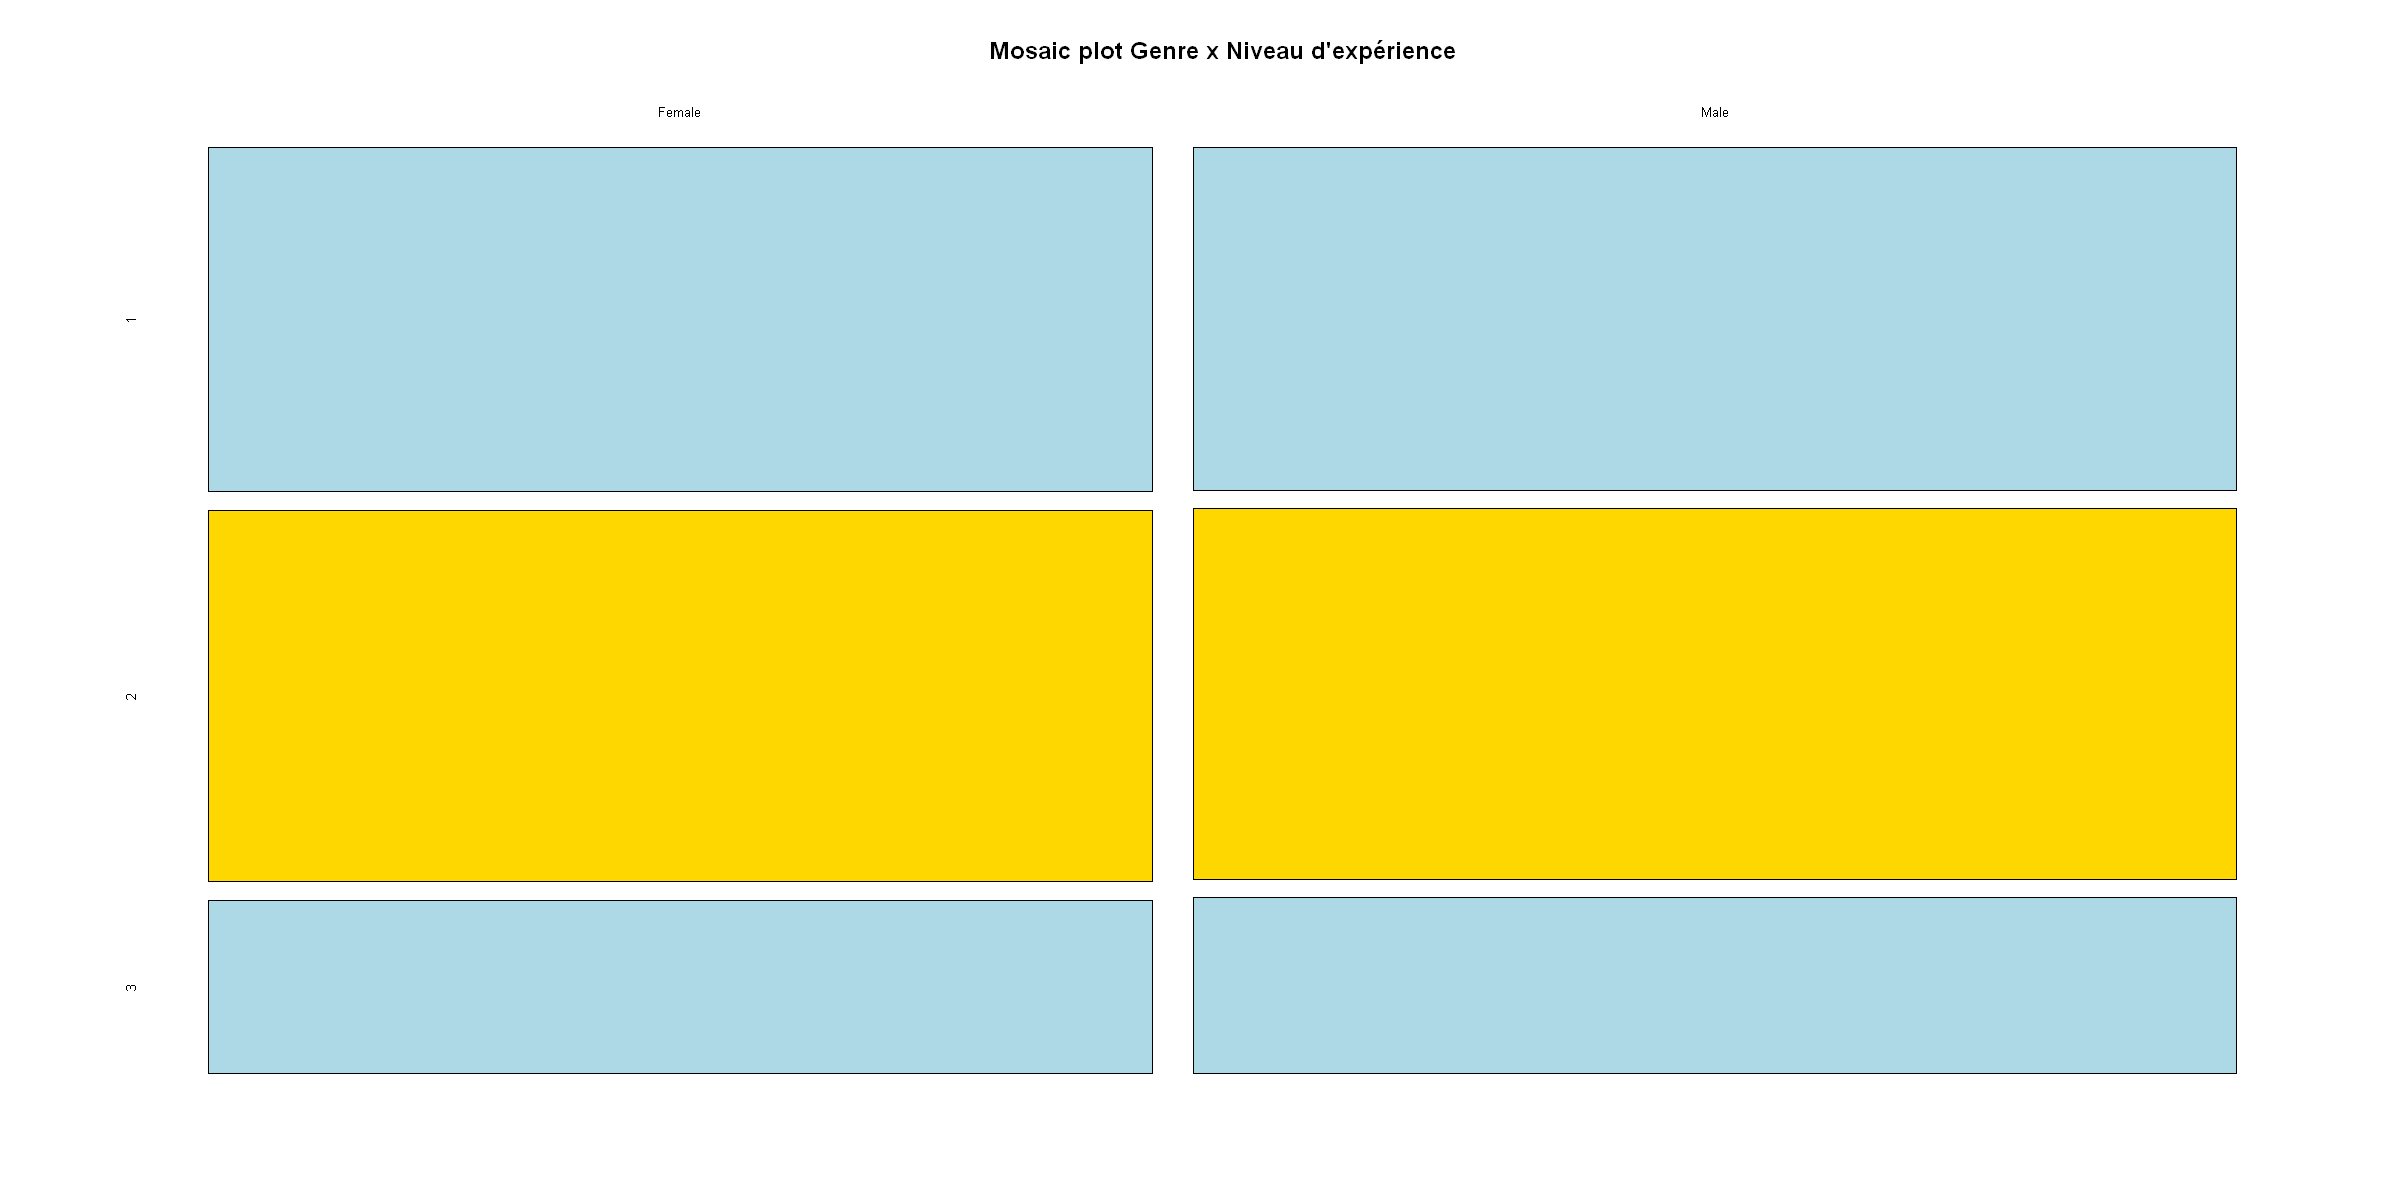

In [15]:
mosaicplot(table(gym$Gender, gym$Experience_Level), main = "Mosaic plot Genre x Niveau d'expérience", color = c("lightblue", "gold"))



Genre x Niveau d'expérience : Les hommes et les femmes ont des niveaux d'expérience similaires.


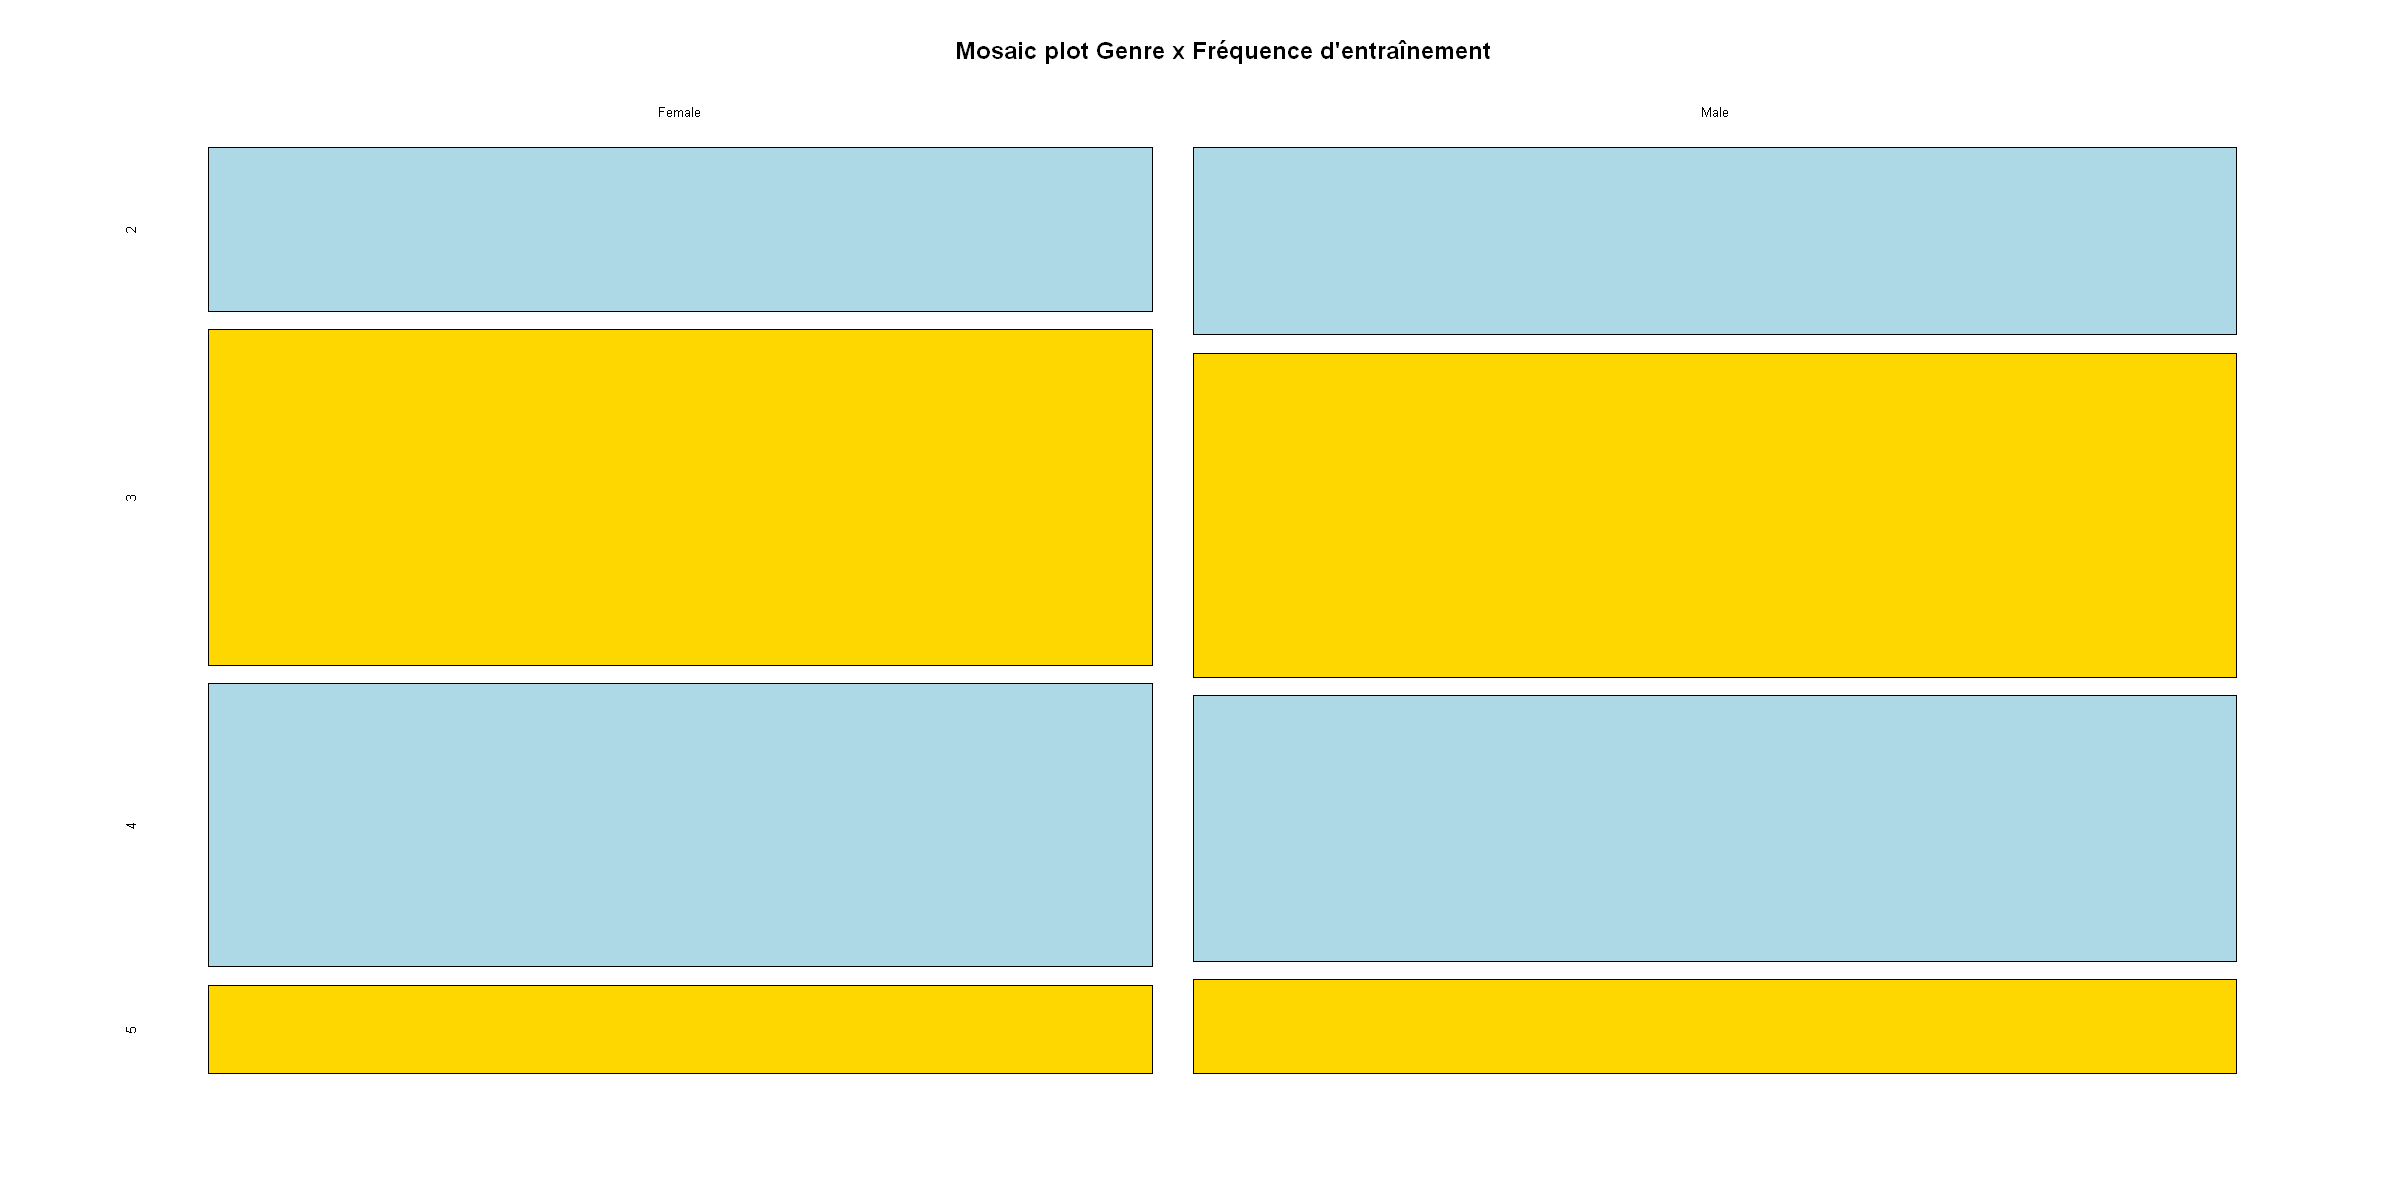

In [16]:
mosaicplot(table(gym$Gender, gym$Workout_Frequency..days.week.), main = "Mosaic plot Genre x Fréquence d'entraînement", color = c("lightblue", "gold"))

Genre x Fréquence d'entraînement : Les hommes et les femmes ont des fréquences d'entraînement similaires.


In [17]:
# selectionner les variables quantitatives
gym_quanti = gym %>% select (Age, LWeight, Height..m., Max_BPM, Avg_BPM, Resting_BPM, Session_Duration..hours., Calories_Burned, SFat_Percentage, Water_Intake..liters.)

### Diagramme des corrélations

In [18]:
cor(gym_quanti)

,Age,LWeight,Height..m.,Max_BPM,Avg_BPM,Resting_BPM,Session_Duration..hours.,Calories_Burned,SFat_Percentage,Water_Intake..liters.
Age,1.0000000000,-0.037761214,-0.027837495,-0.017072597,0.035969143,0.004353714,-0.01991190,-0.154678760,0.0007184487,0.041528359
LWeight,-0.0377612140,1.000000000,0.362213868,0.055768353,0.003475867,-0.037667108,0.01863692,0.123193552,0.2721408512,0.407361618
Height..m.,-0.0278374949,0.362213868,1.000000000,-0.017659884,-0.014776288,-0.005089864,-0.01020590,0.086348051,0.2573916107,0.393532902
Max_BPM,-0.0170725970,0.055768353,-0.017659884,1.000000000,-0.039751443,0.036647481,0.01005098,0.002090016,0.0065041497,0.031620643
Avg_BPM,0.0359691433,0.003475867,-0.014776288,-0.039751443,1.000000000,0.059635502,0.01601444,0.339658667,0.0090512522,-0.002910637
Resting_BPM,0.0043537136,-0.037667108,-0.005089864,0.036647481,0.059635502,1.000000000,-0.01664881,0.016517951,0.0116810255,0.007725998
Session_Duration..hours.,-0.0199119043,0.018636920,-0.010205897,0.010050981,0.016014438,-0.016648808,1.00000000,0.908140376,0.5239595501,0.283410977
Calories_Burned,-0.1546787599,0.123193552,0.086348051,0.002090016,0.339658667,0.016517951,0.90814038,1.000000000,0.5489262407,0.356930683
SFat_Percentage,0.0007184487,0.272140851,0.257391611,0.006504150,0.009051252,0.011681025,0.52395955,0.548926241,1.0000000000,0.580875861
Water_Intake..liters.,0.0415283591,0.407361618,0.393532902,0.031620643,-0.002910637,0.007725998,0.28341098,0.356930683,0.5808758610,1.000000000


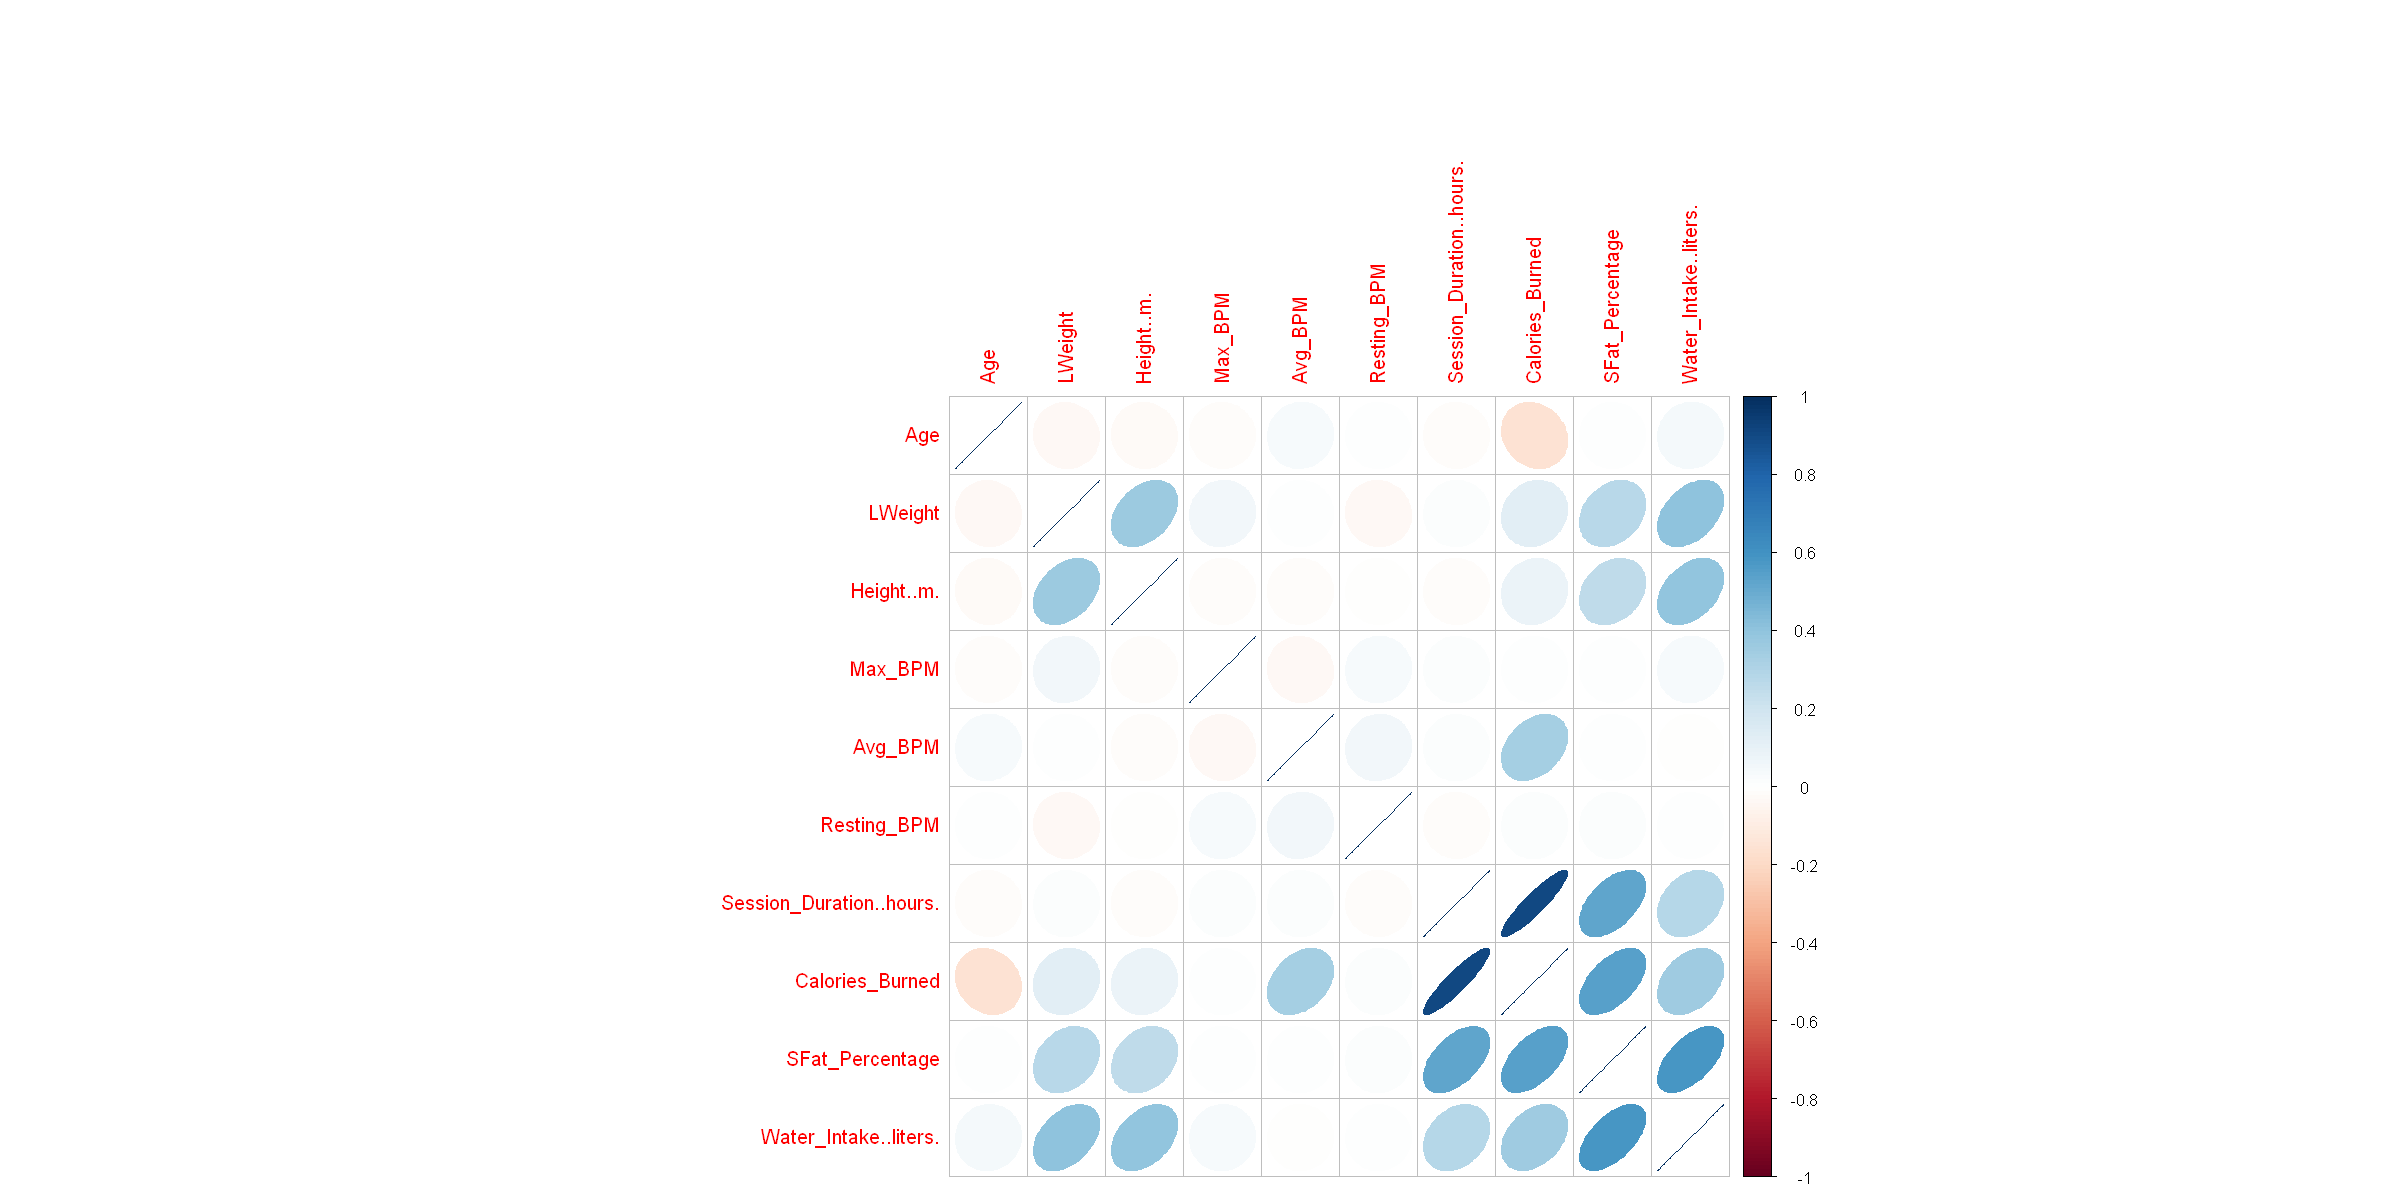

In [19]:
corrplot(cor(gym_quanti), method = "ellipse")

```markdown
Le corrplot ci-dessous montre les corrélations entre les variables quantitatives du jeu de données. Voici quelques observations clés :

- Une forte corrélation positive existe entre la durée de l'exercice (Session Duration) et les calories brûlées (Calories Burned), avec un coefficient de corrélation de 0.91. Cela correspond à l'attente selon laquelle une durée d'exercice plus longue conduit généralement à une augmentation des calories brûlées.
- Une moyenne correlation entre Calories Burned et SFat_Percentage (r = 0.55): Les individus avec plus de graisse brûleraient potentiellement plus de calories pendant l'exercice (masse corporelle plus élevée).
- Une moyenne correlation entre SFat_Percentage et Water Intake (r = 0.58) Surprenant : une hydratation accrue pourrait être liée à des régimes ou à des pratiques de gestion du poids.
Ces corrélations peuvent aider à identifier les relations entre les variables et à guider les analyses ultérieures, telles que la sélection de variables pour les modèles prédictifs.
```

## ACP

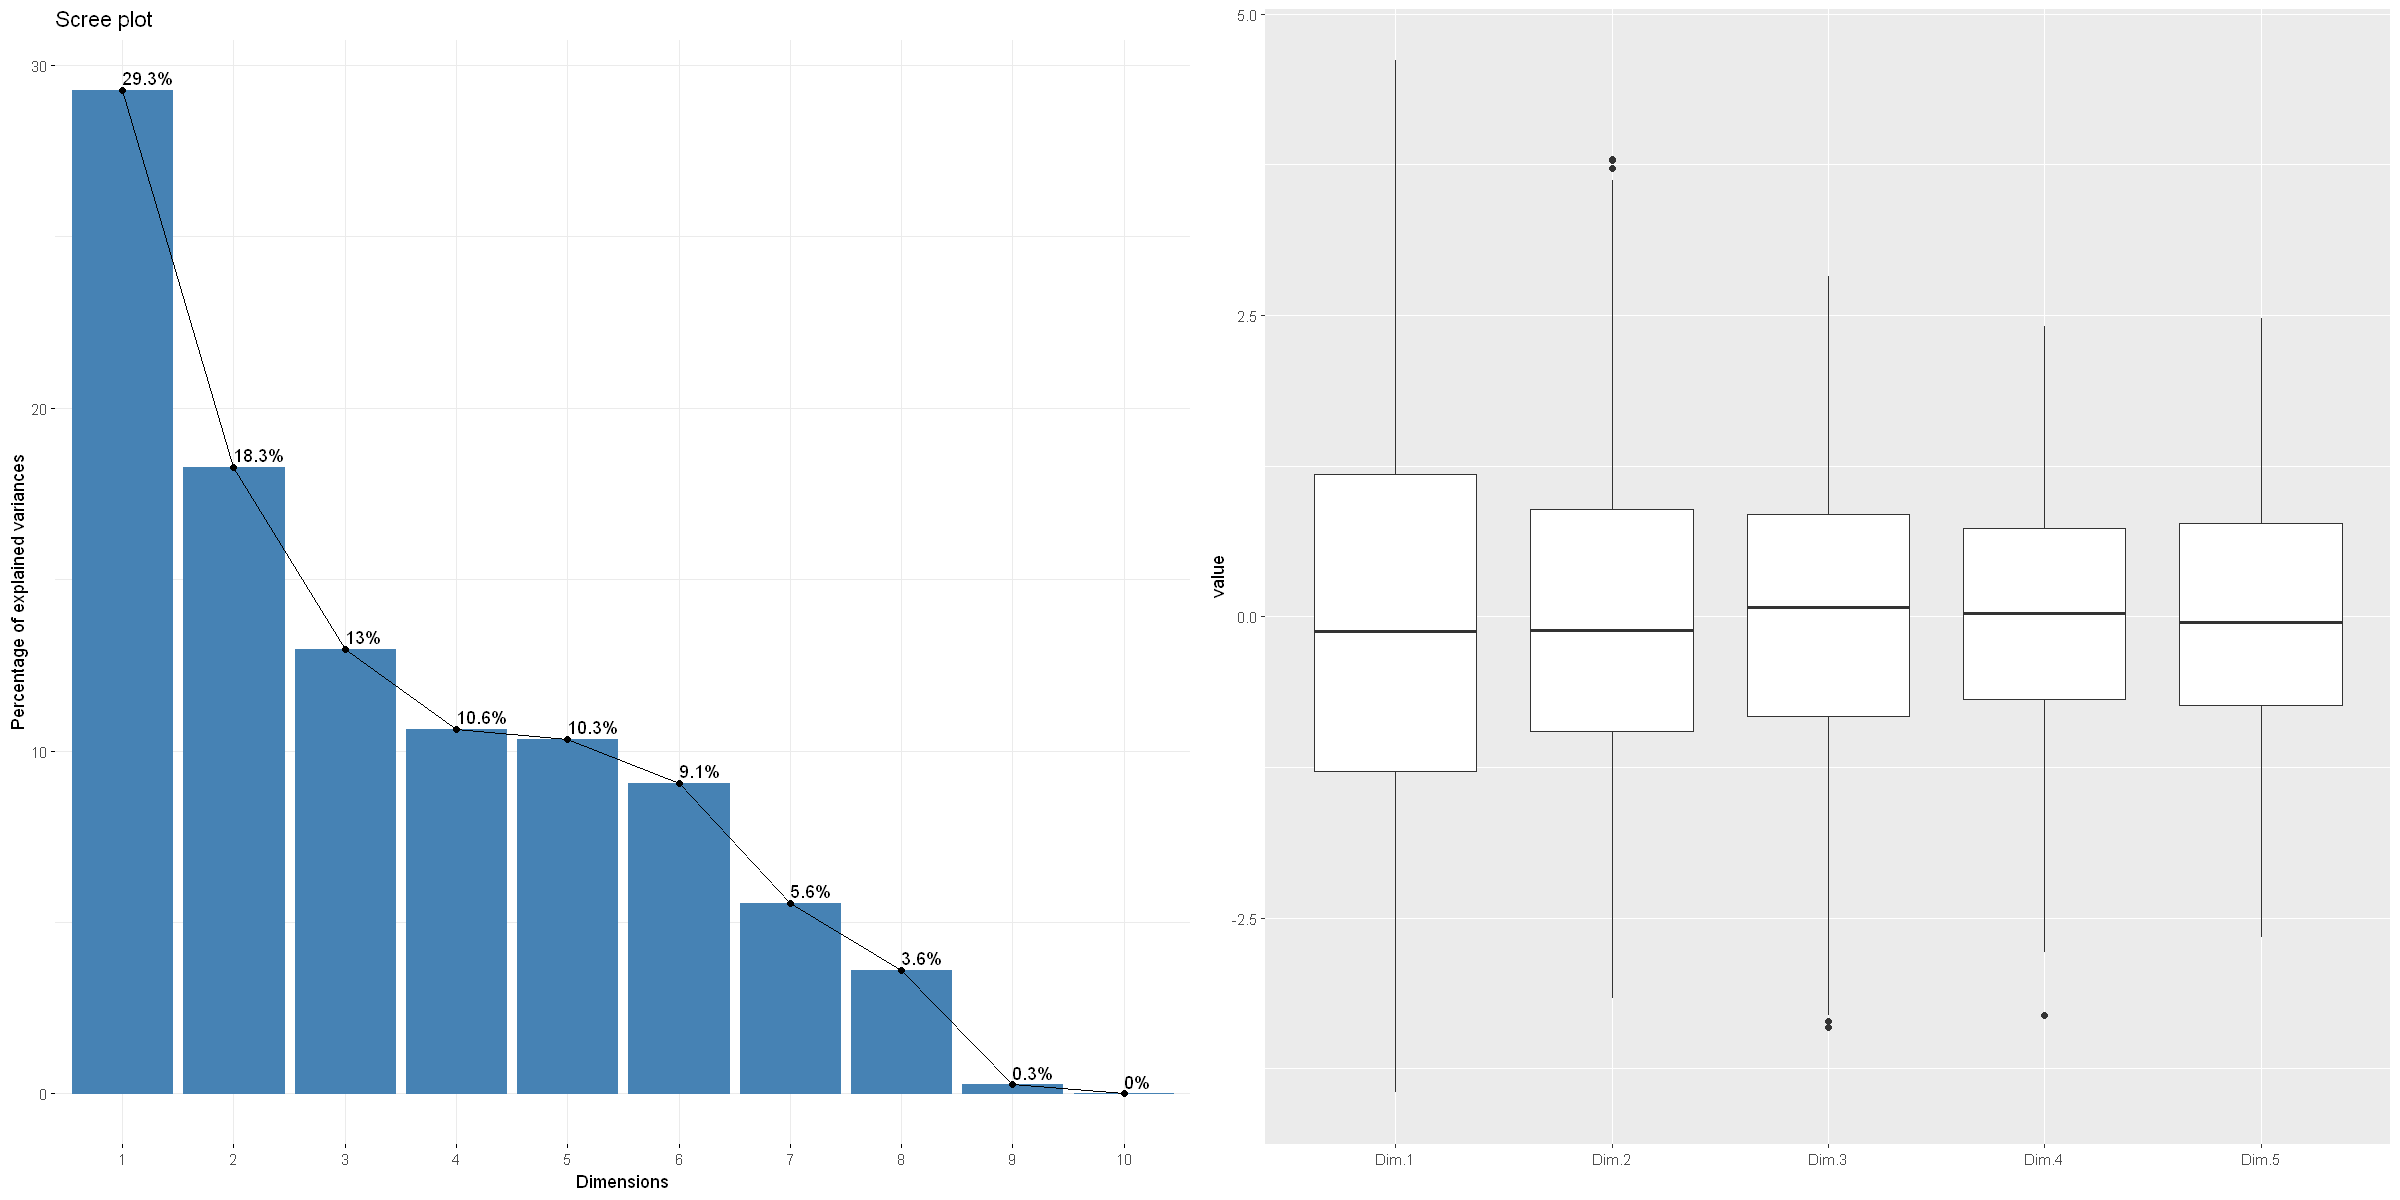

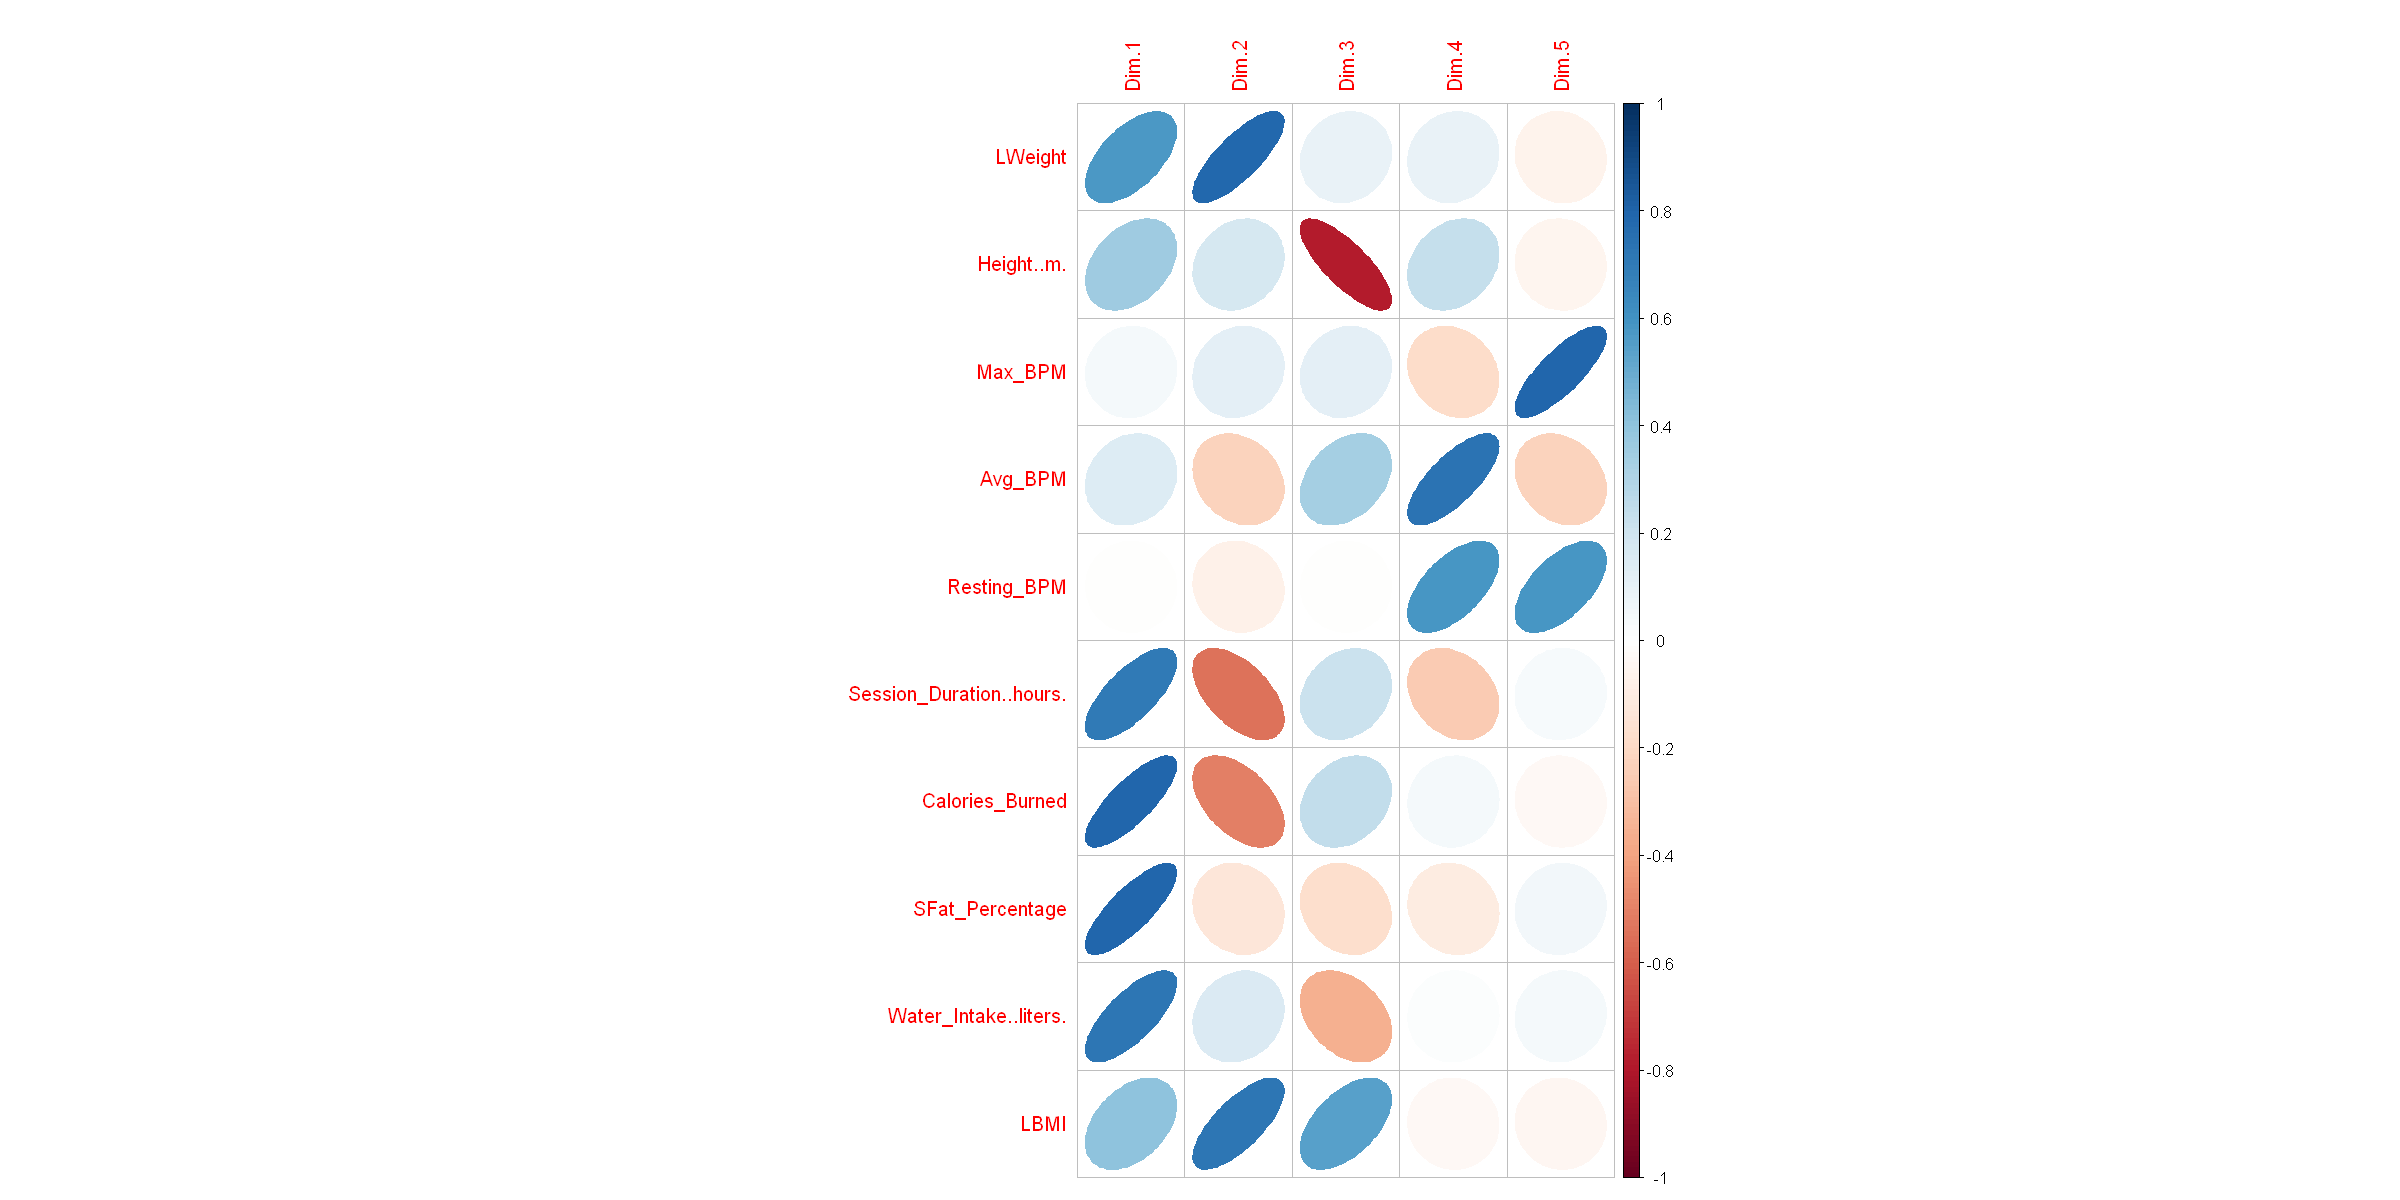

In [20]:
# acp <- PCA(gym[, c(1, 3:9, 11:12, 15)], scale.unit = TRUE, graph = FALSE, quali.sup = 2, quanti.sup = 1, ncp = 5)

acp <- PCA(gym, scale.unit = TRUE, graph = FALSE, quali.sup = c(2, 10, 13, 14) , quanti.sup = 1, ncp = 5)

# ACP réduite

# Décroissance des valeurs propres
library(factoextra)
g1<-fviz_eig(acp, addlabels = TRUE)
library(reshape2)
g2<-ggplot(melt(acp$ind$coord),aes(x=Var2,y=value))+
  geom_boxplot()+
  xlab("")
grid.arrange(g1,g2,ncol=2)

library(corrplot)
corrplot(acp$var$cor, is.corr=TRUE,method="ellipse")

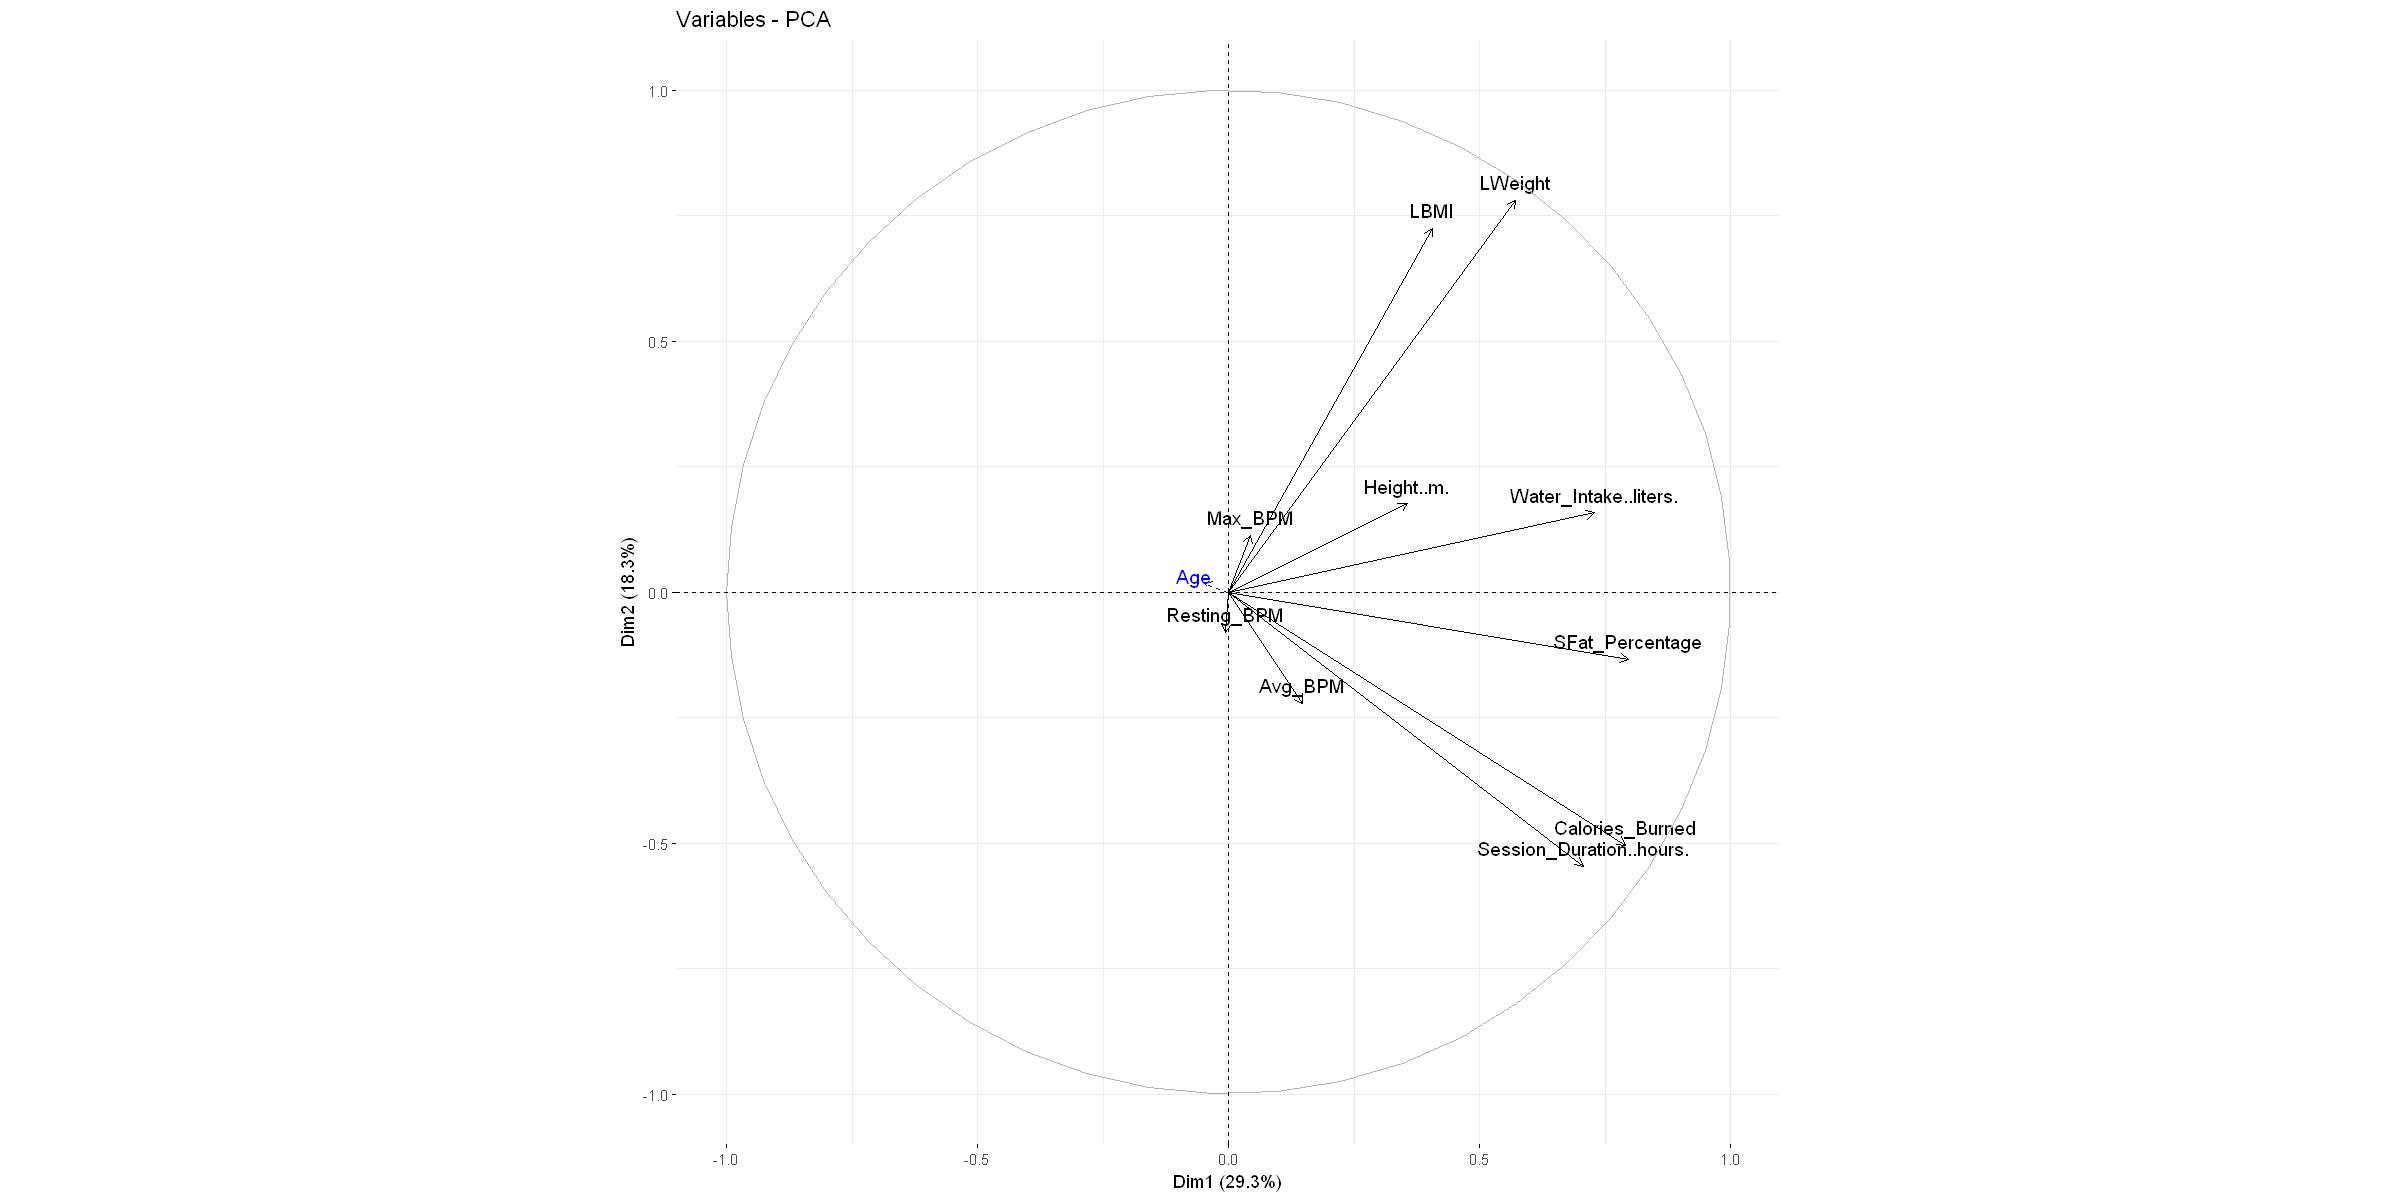

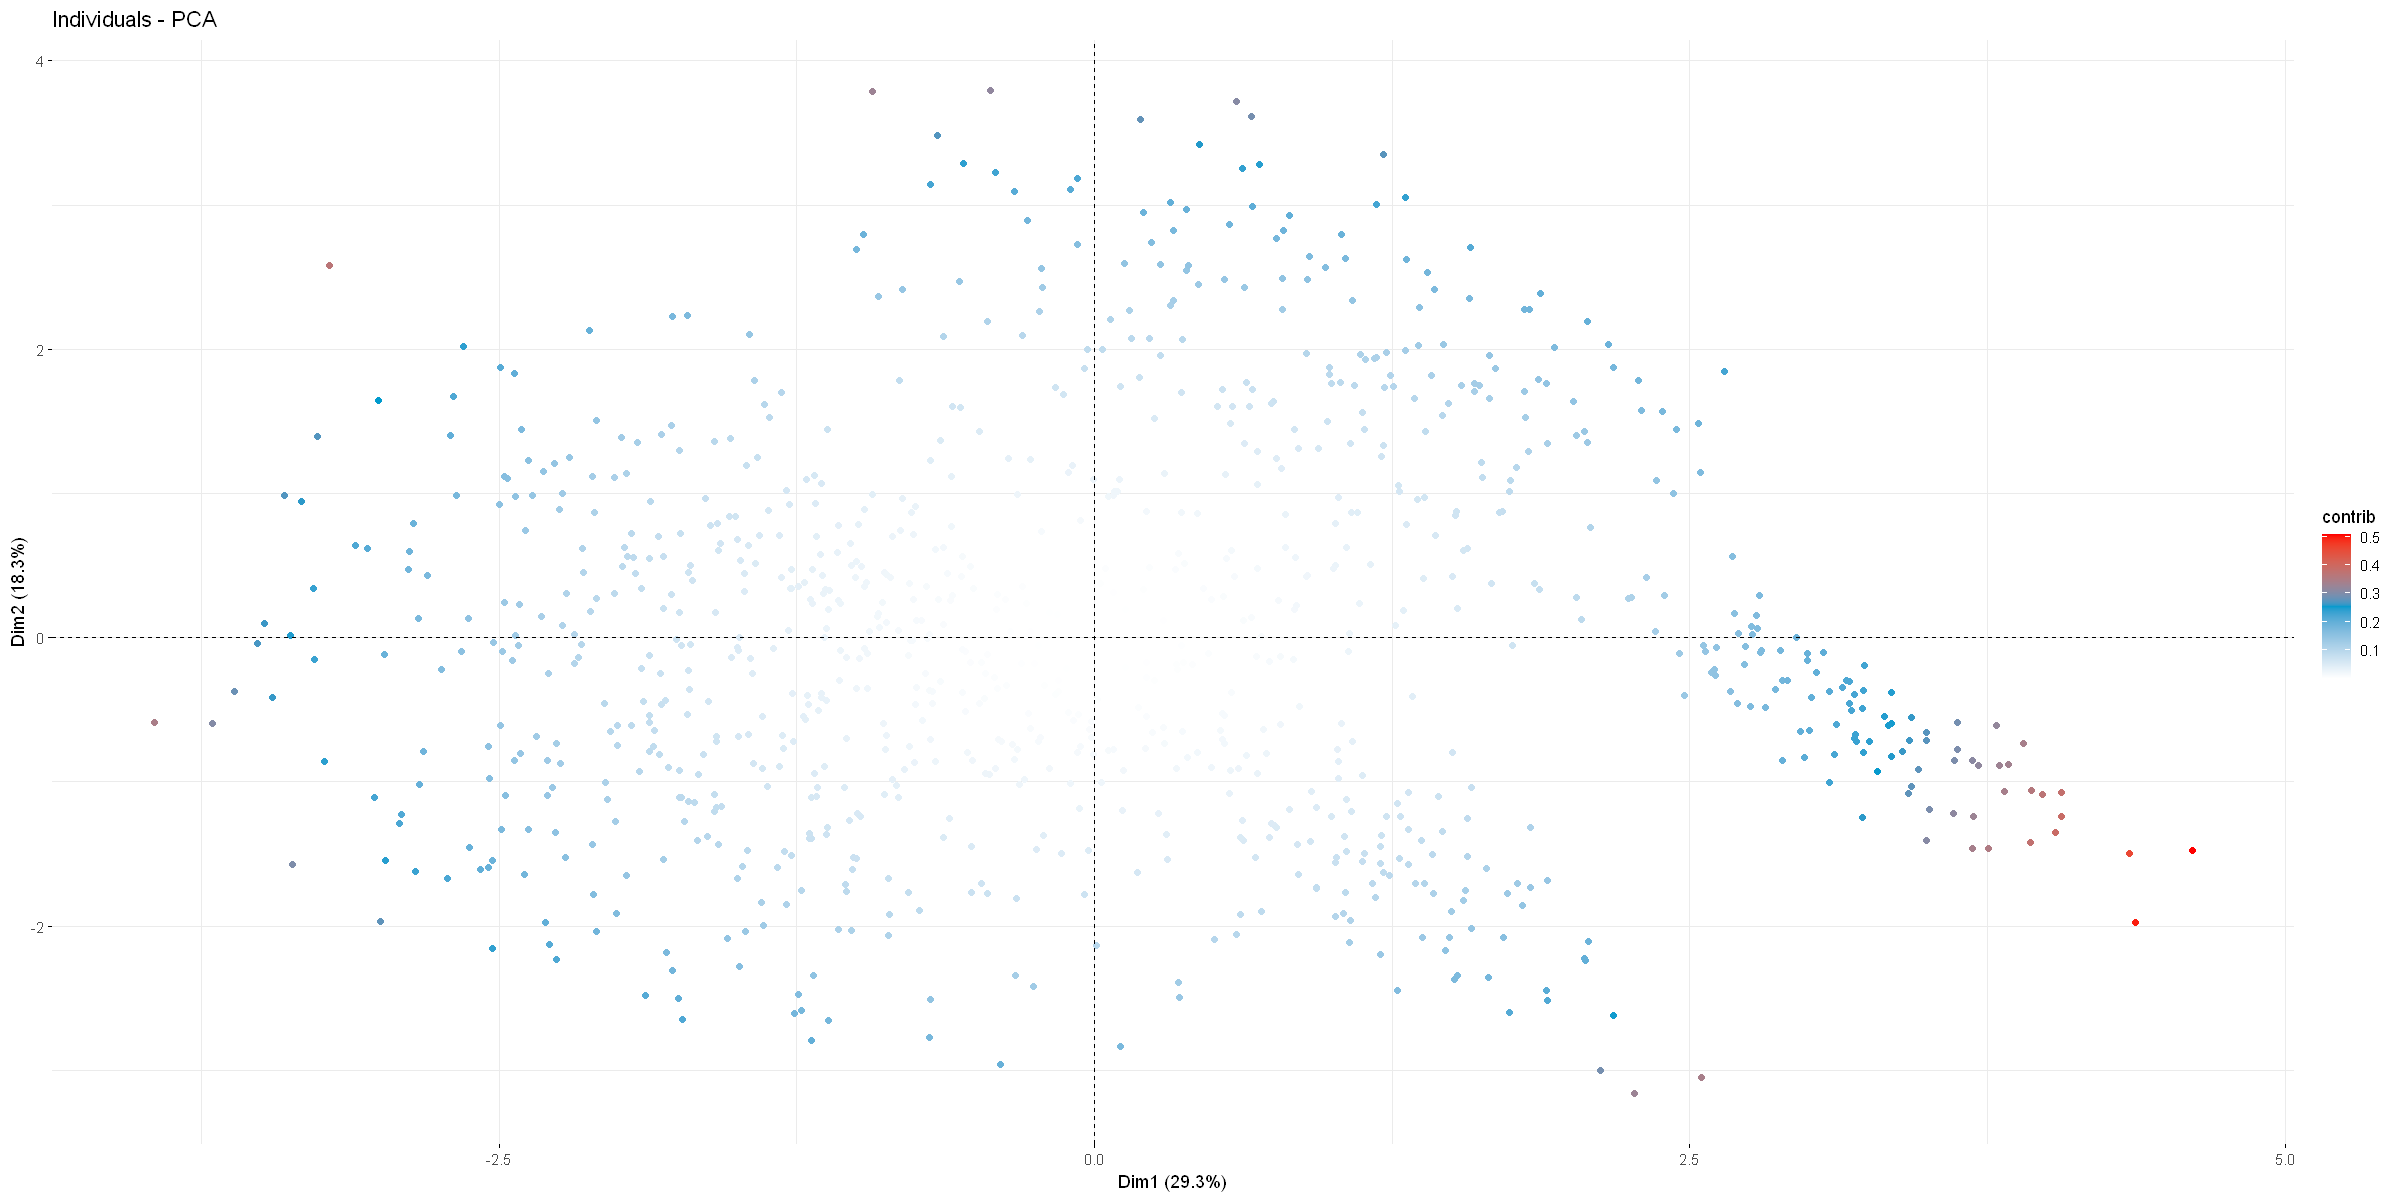

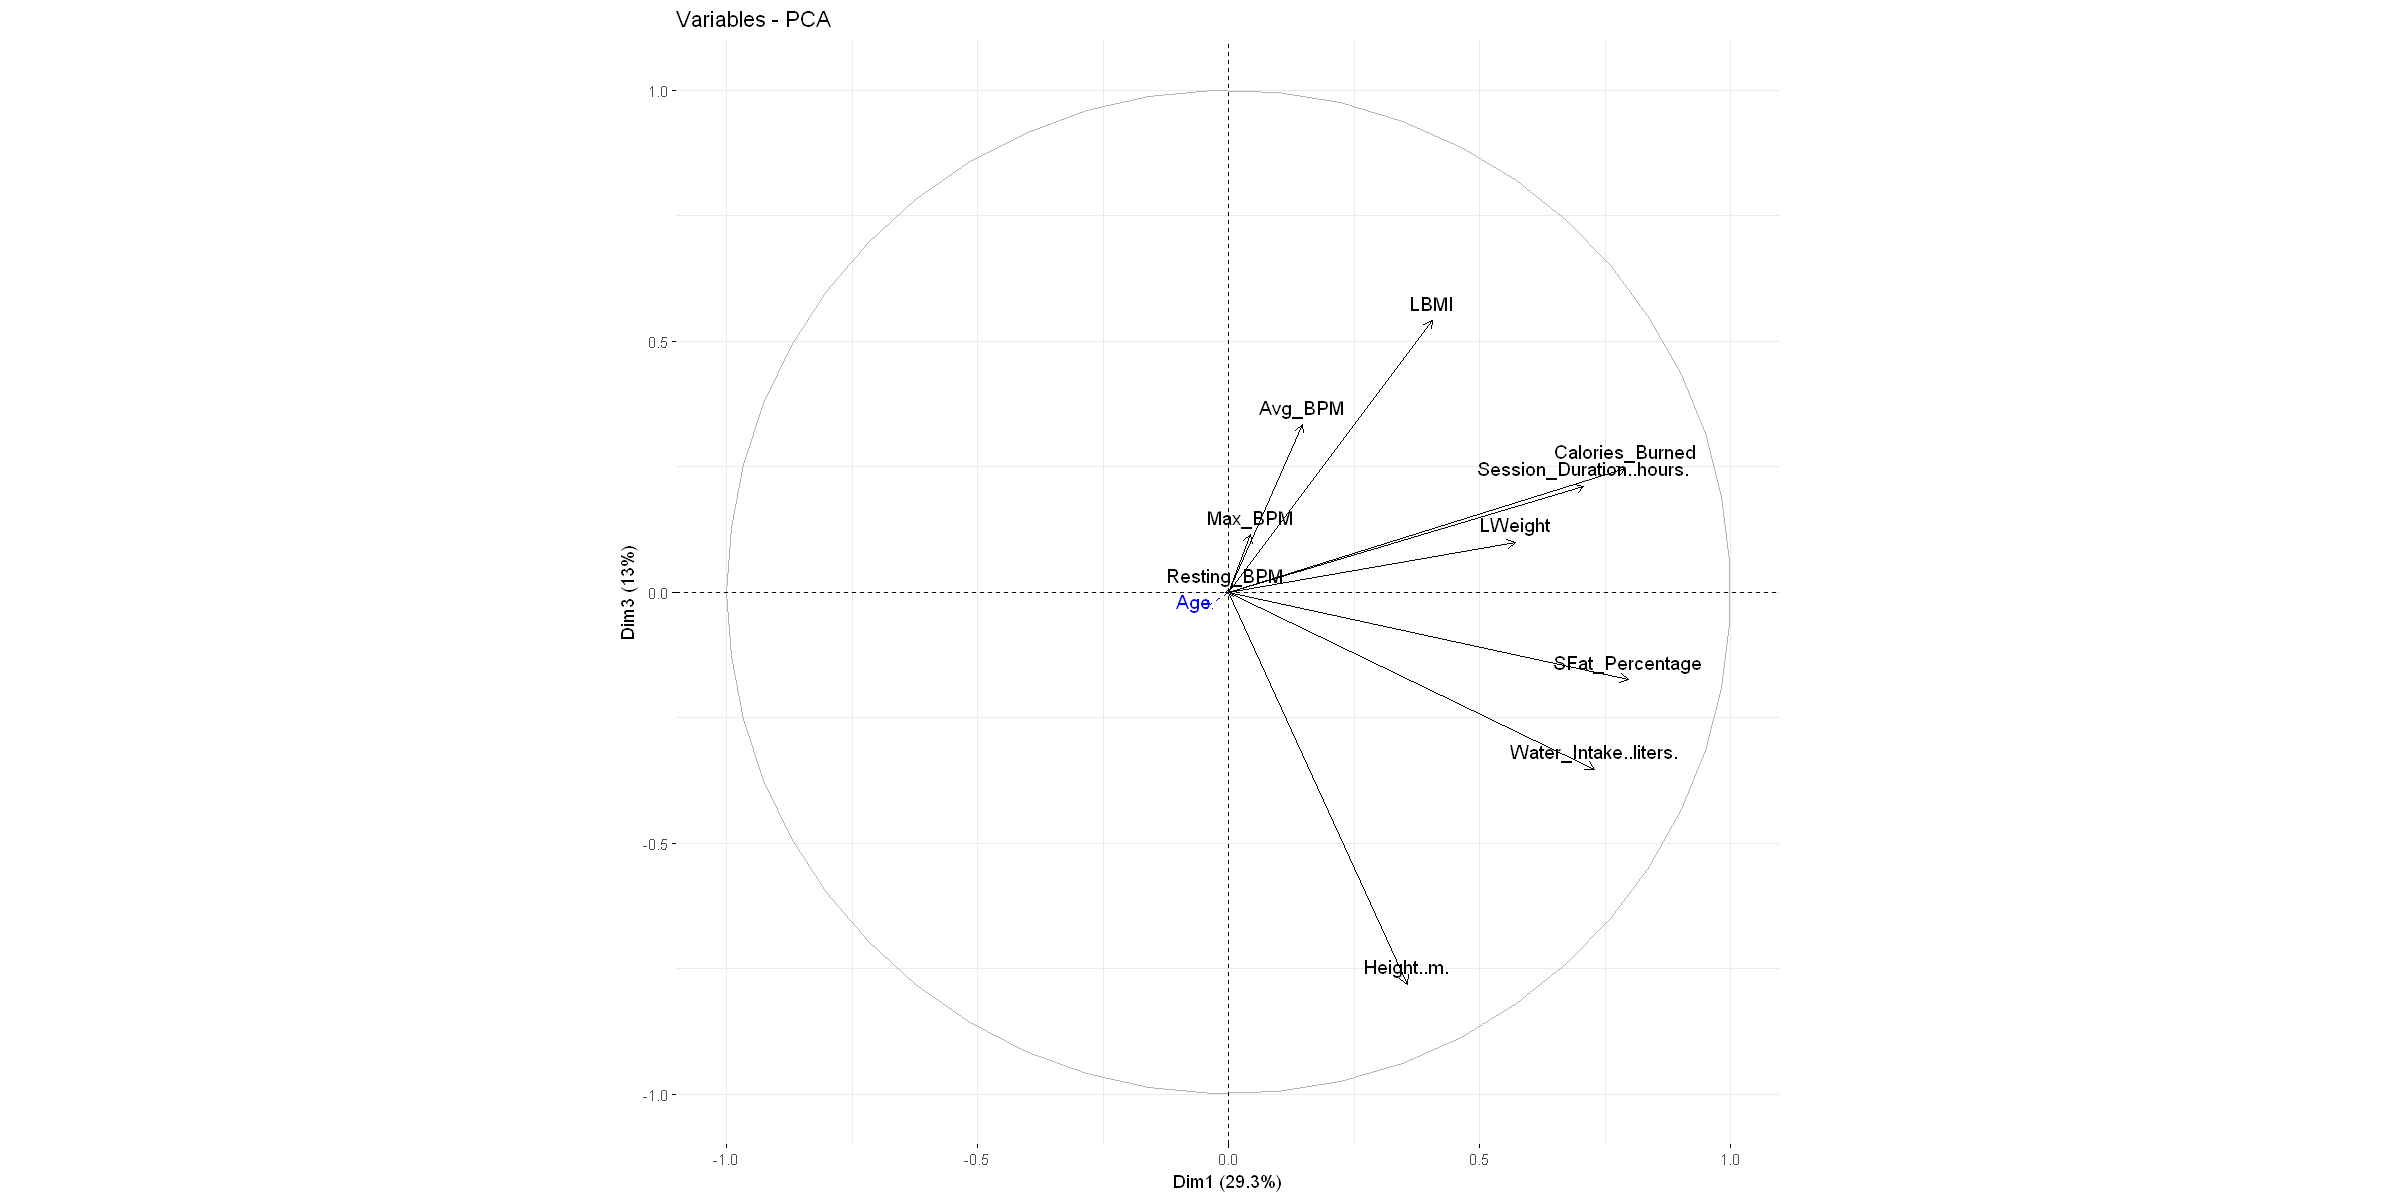

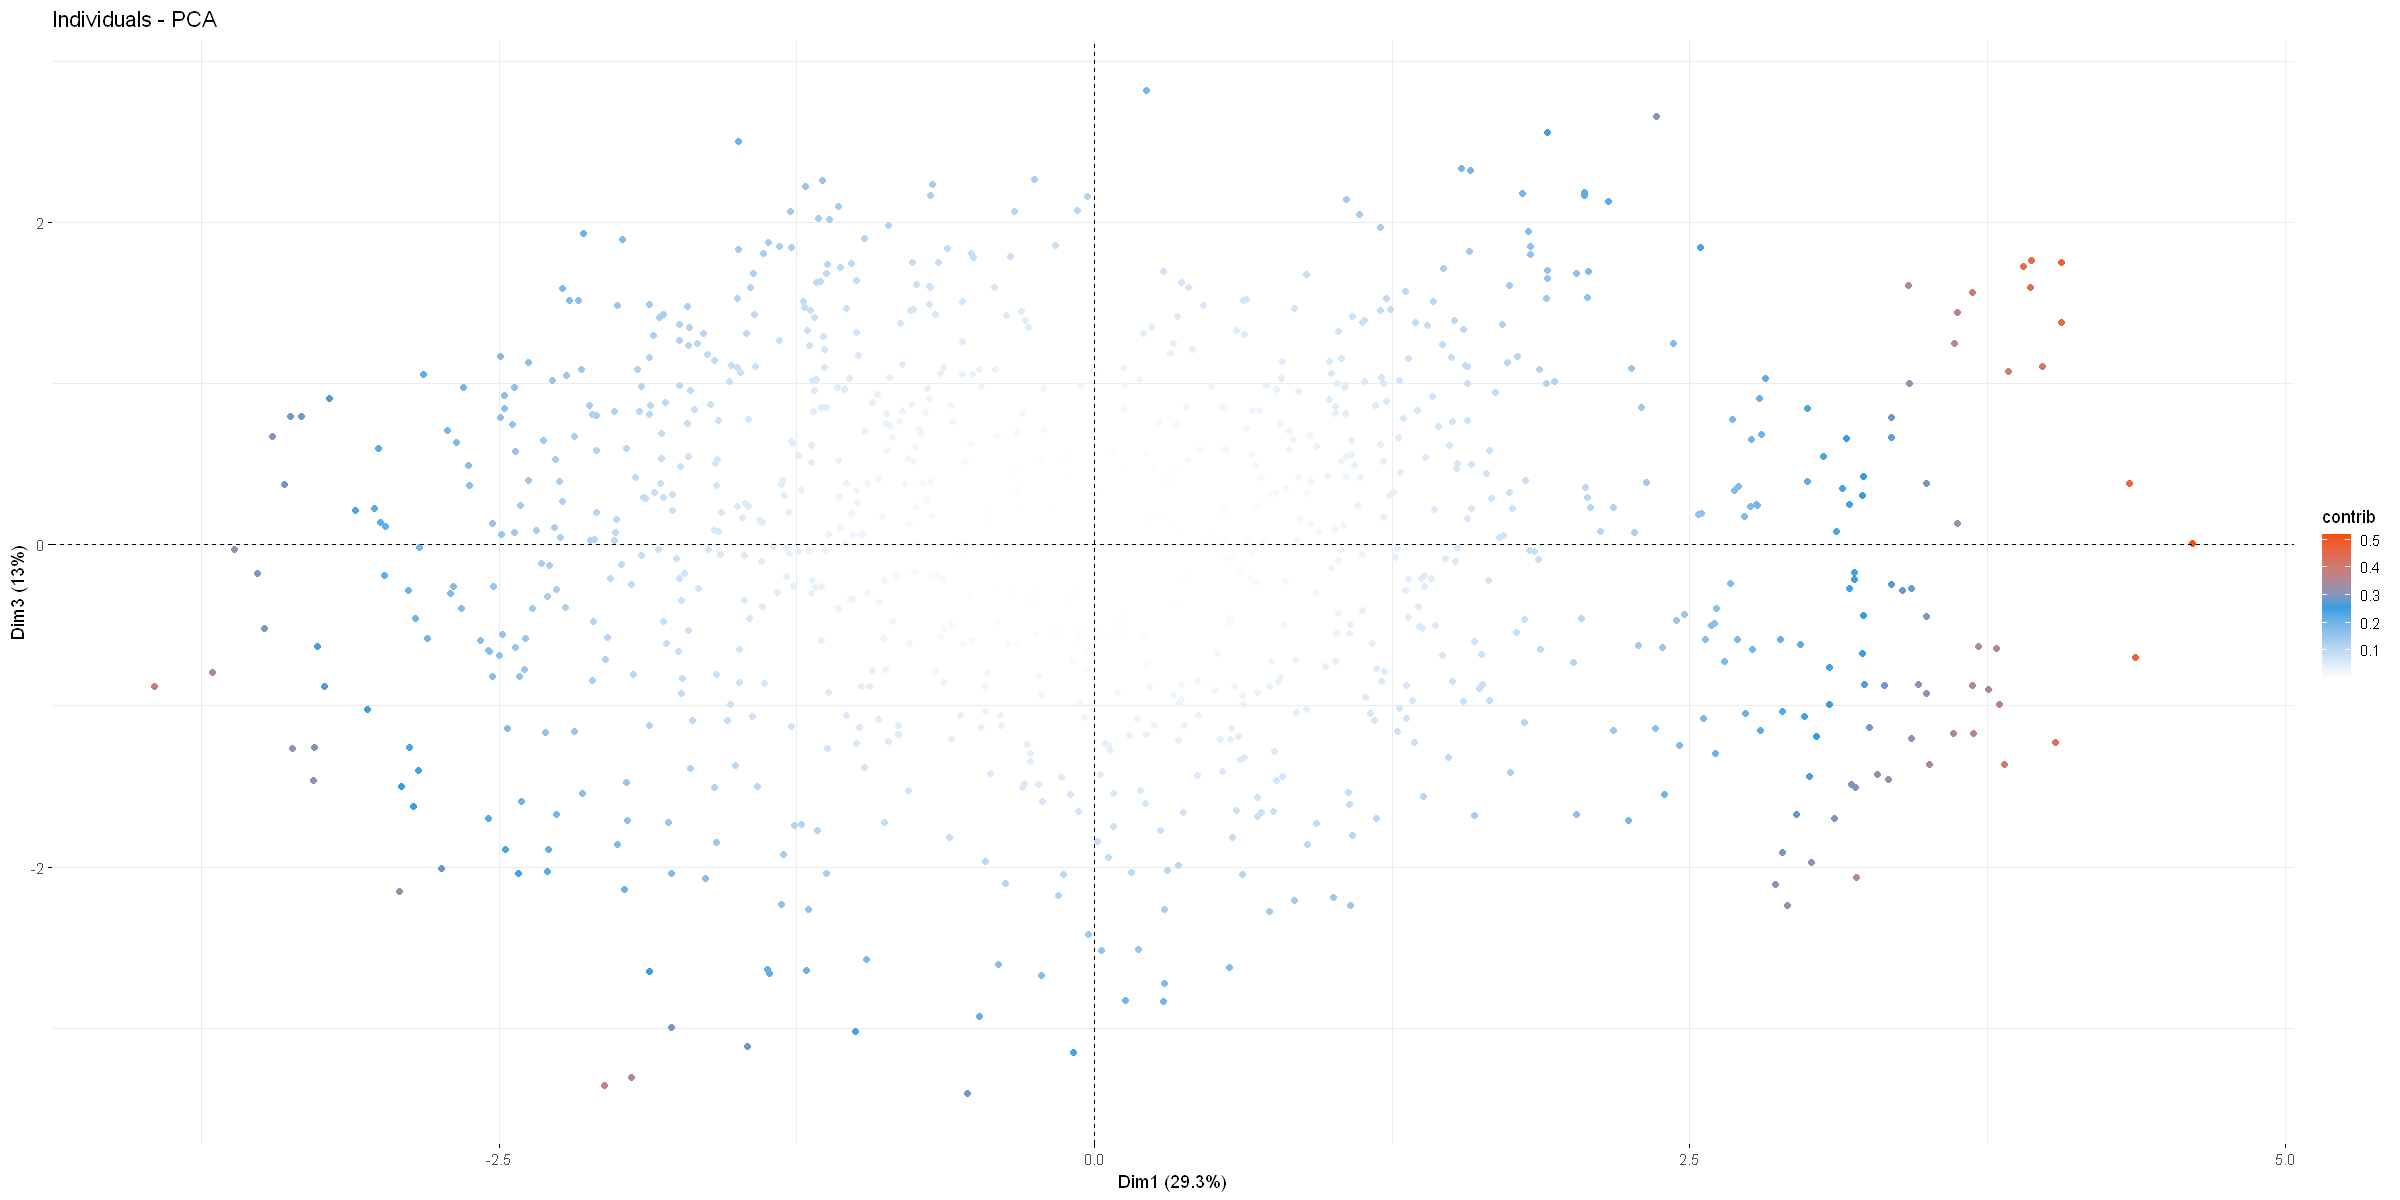

In [21]:
fviz_pca_var(acp)
fviz_pca_ind(acp,col.ind="contrib",label="true",gradient.cols = c("white", "deepskyblue3", "red" ))
fviz_pca_var(acp,axes=c(1,3))
fviz_pca_ind(acp,col.ind="contrib",label="none",gradient.cols = c("white", "#2E9FDF", "#FC4E07" ),axes=c(1,3))

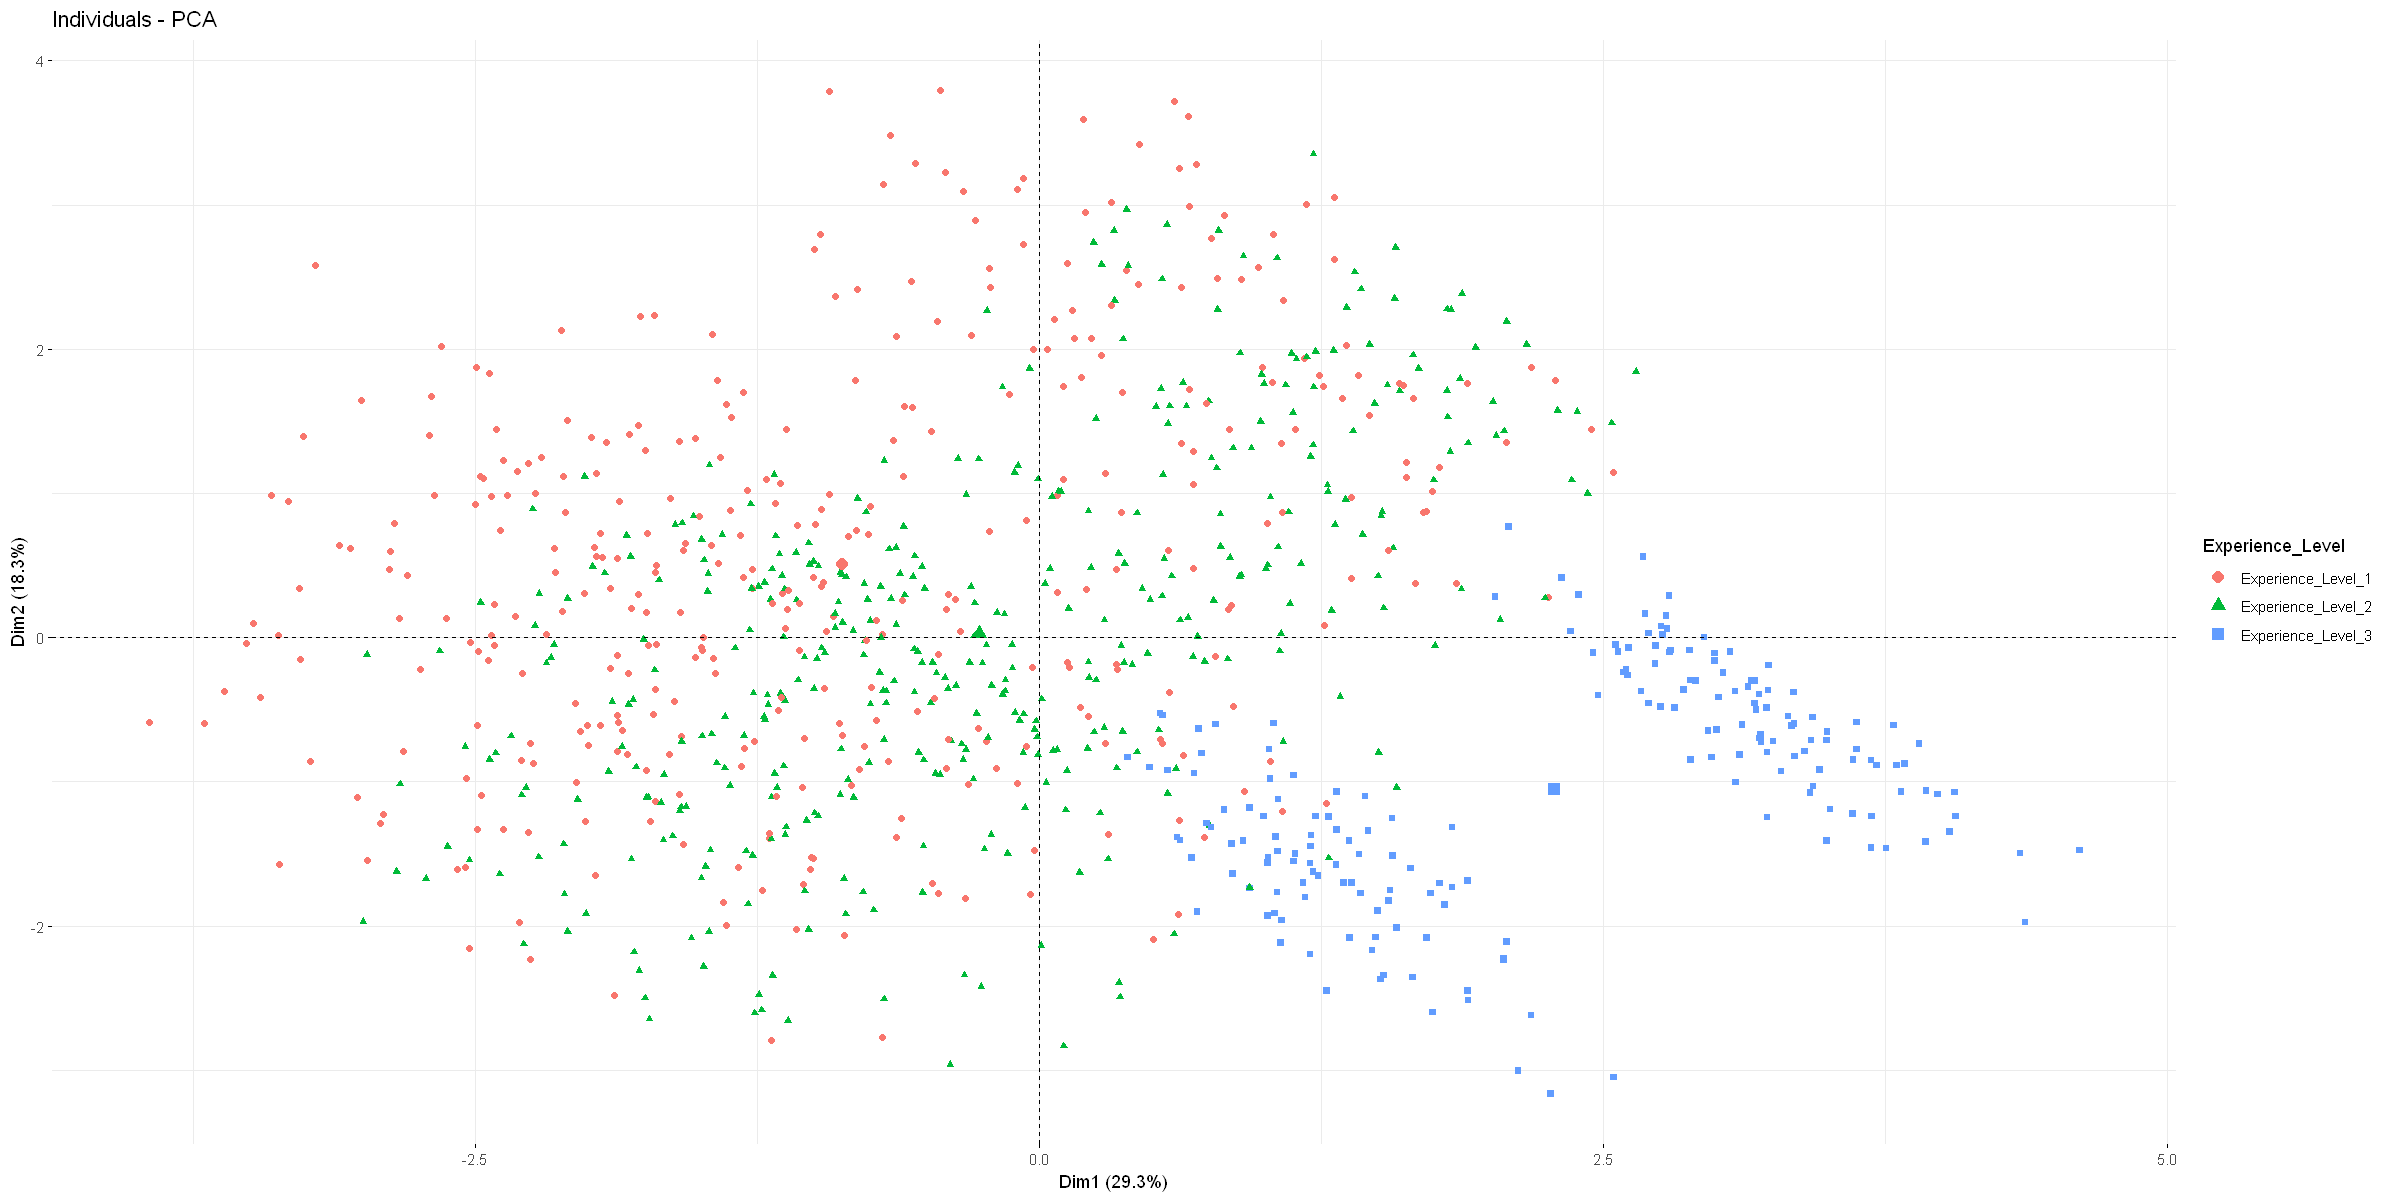

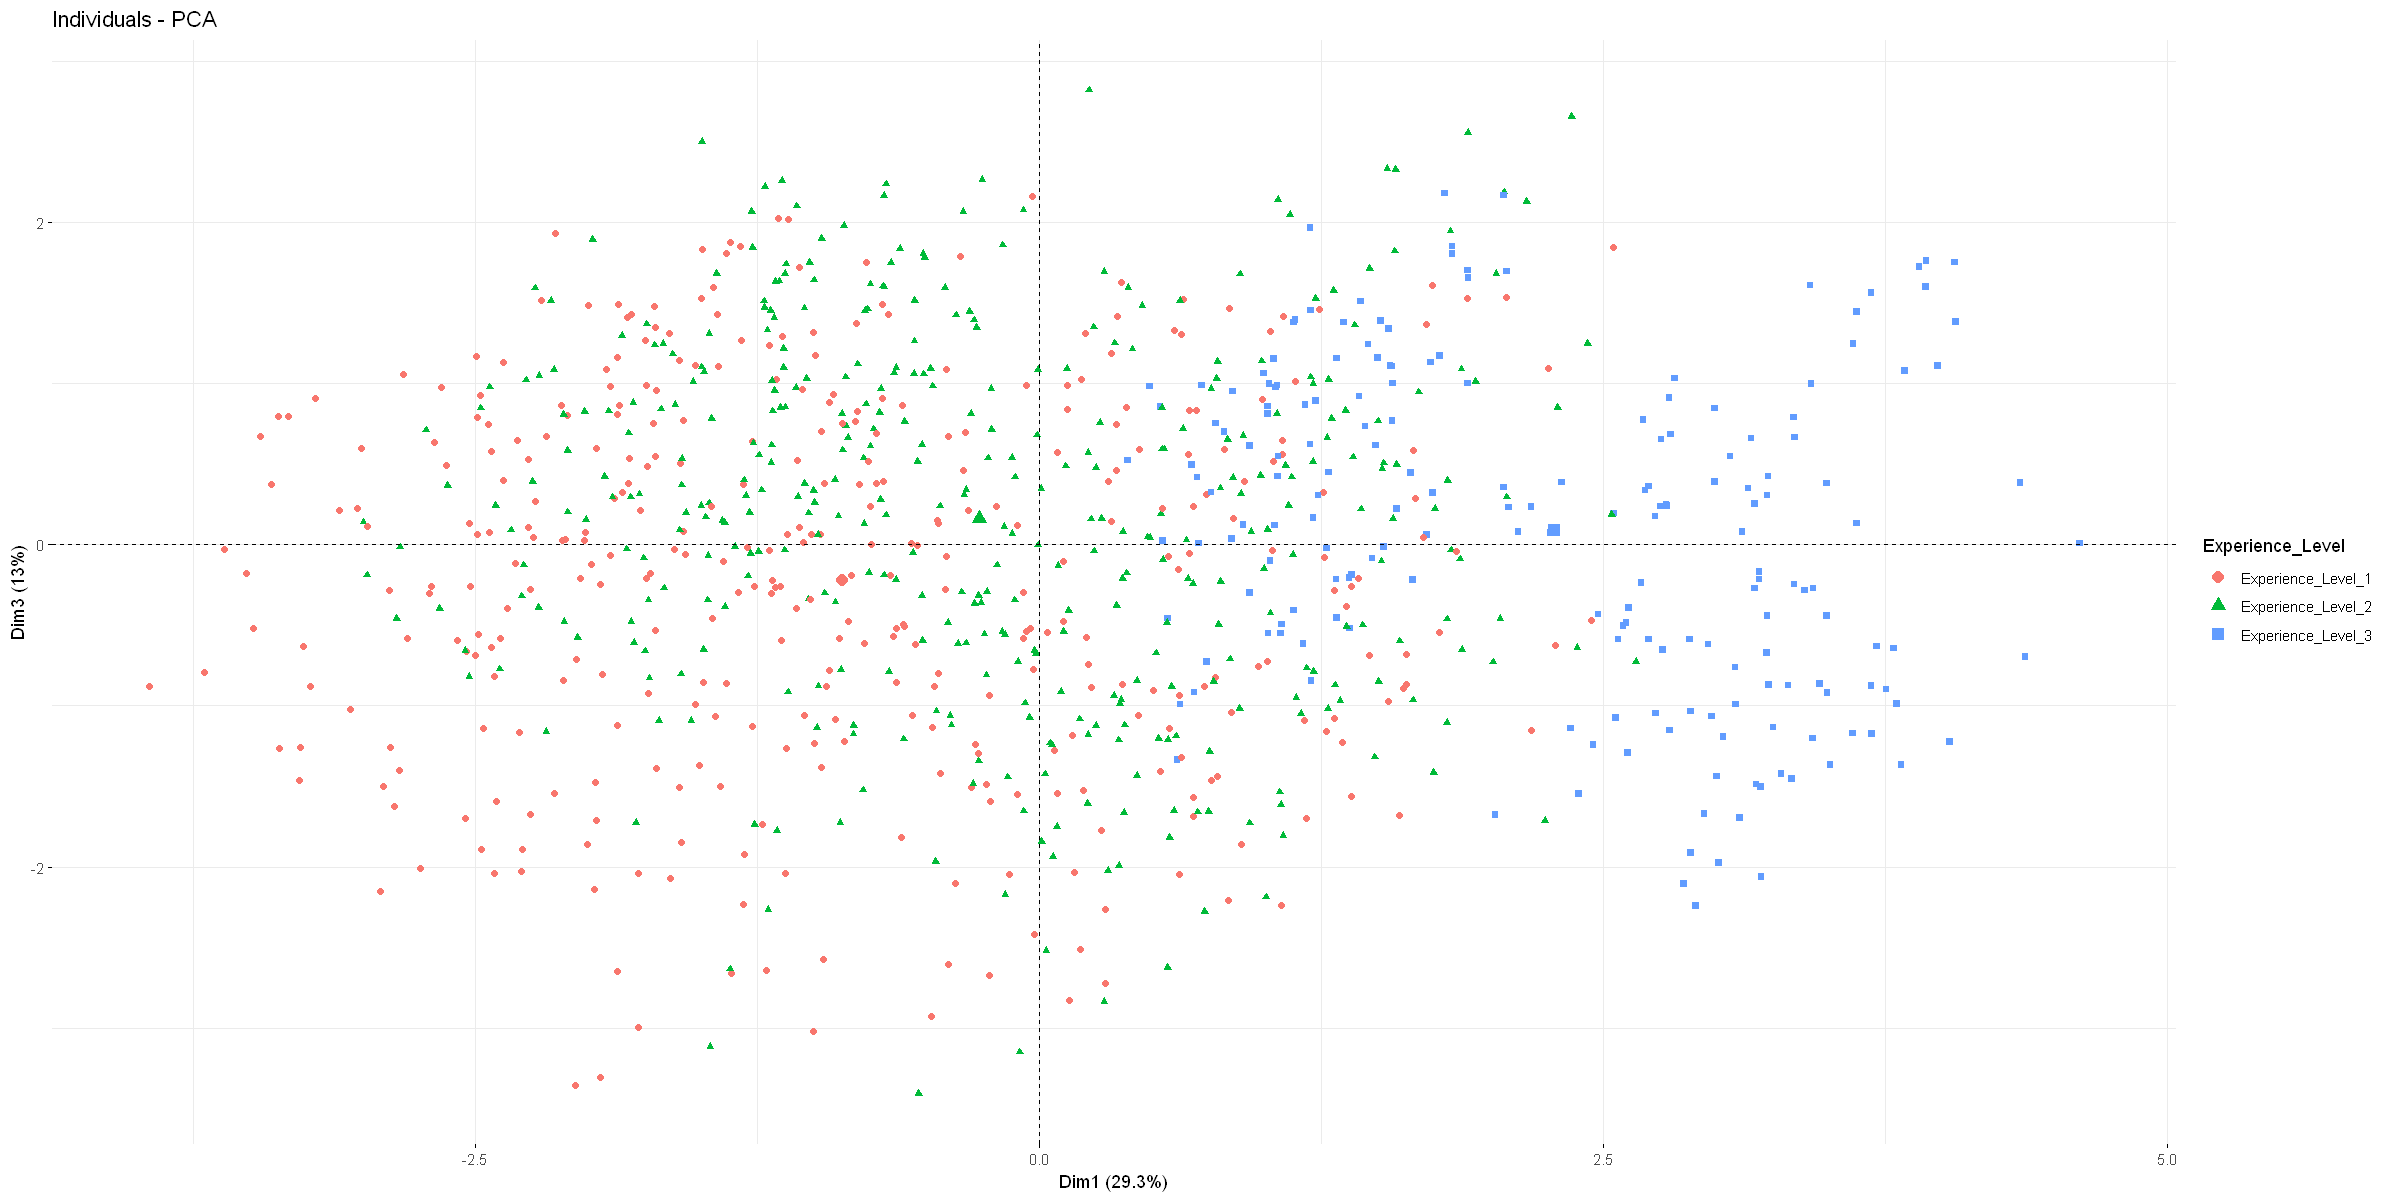

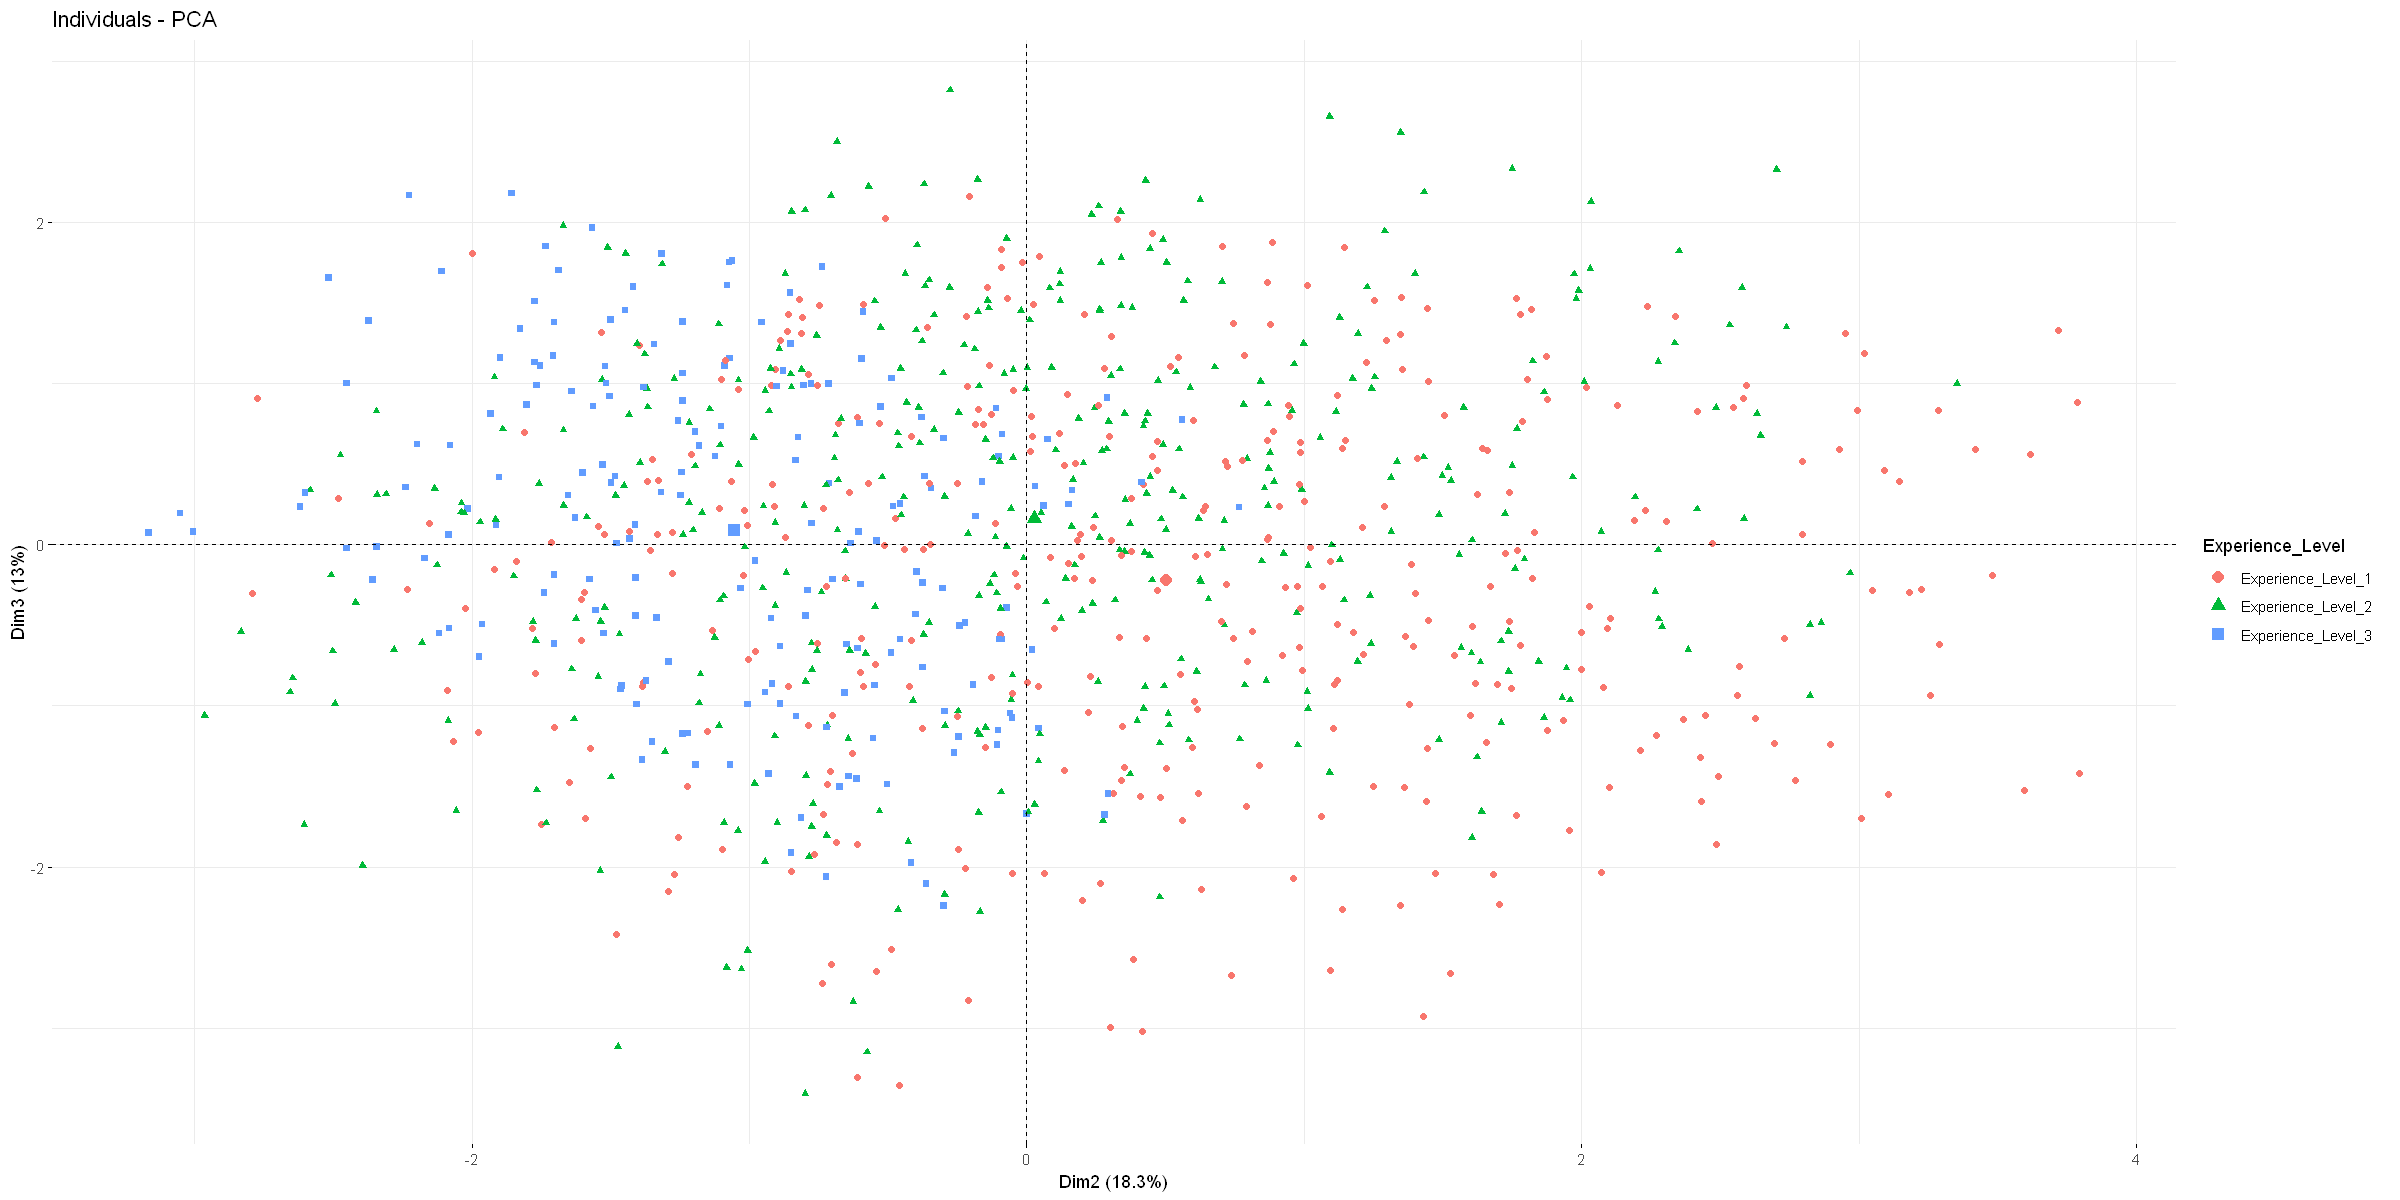

In [22]:
fviz_pca_ind(acp, label="none", habillage = 14, axes=c(1,2))
fviz_pca_ind(acp, label="none", habillage = 14, axes=c(1,3))
fviz_pca_ind(acp, label="none", habillage = 14, axes=c(2,3))


Attachement du package : 'MASS'


L'objet suivant est masqué depuis 'package:plotly':

    select


L'objet suivant est masqué depuis 'package:dplyr':

    select




,LD1,LD2
Age,-0.020565358,-0.025601622
LWeight,-0.439958982,-1.024305222
Height..m.,-1.335820726,-0.576542180
Max_BPM,0.001008299,0.008607209
Avg_BPM,0.029182223,0.038526342
Resting_BPM,0.005776300,0.004191863
Session_Duration..hours.,7.206410691,1.729432548
Calories_Burned,-0.005315404,-0.006874264
SFat_Percentage,1.149753648,0.957898014
Water_Intake..liters.,0.353205343,0.853591703


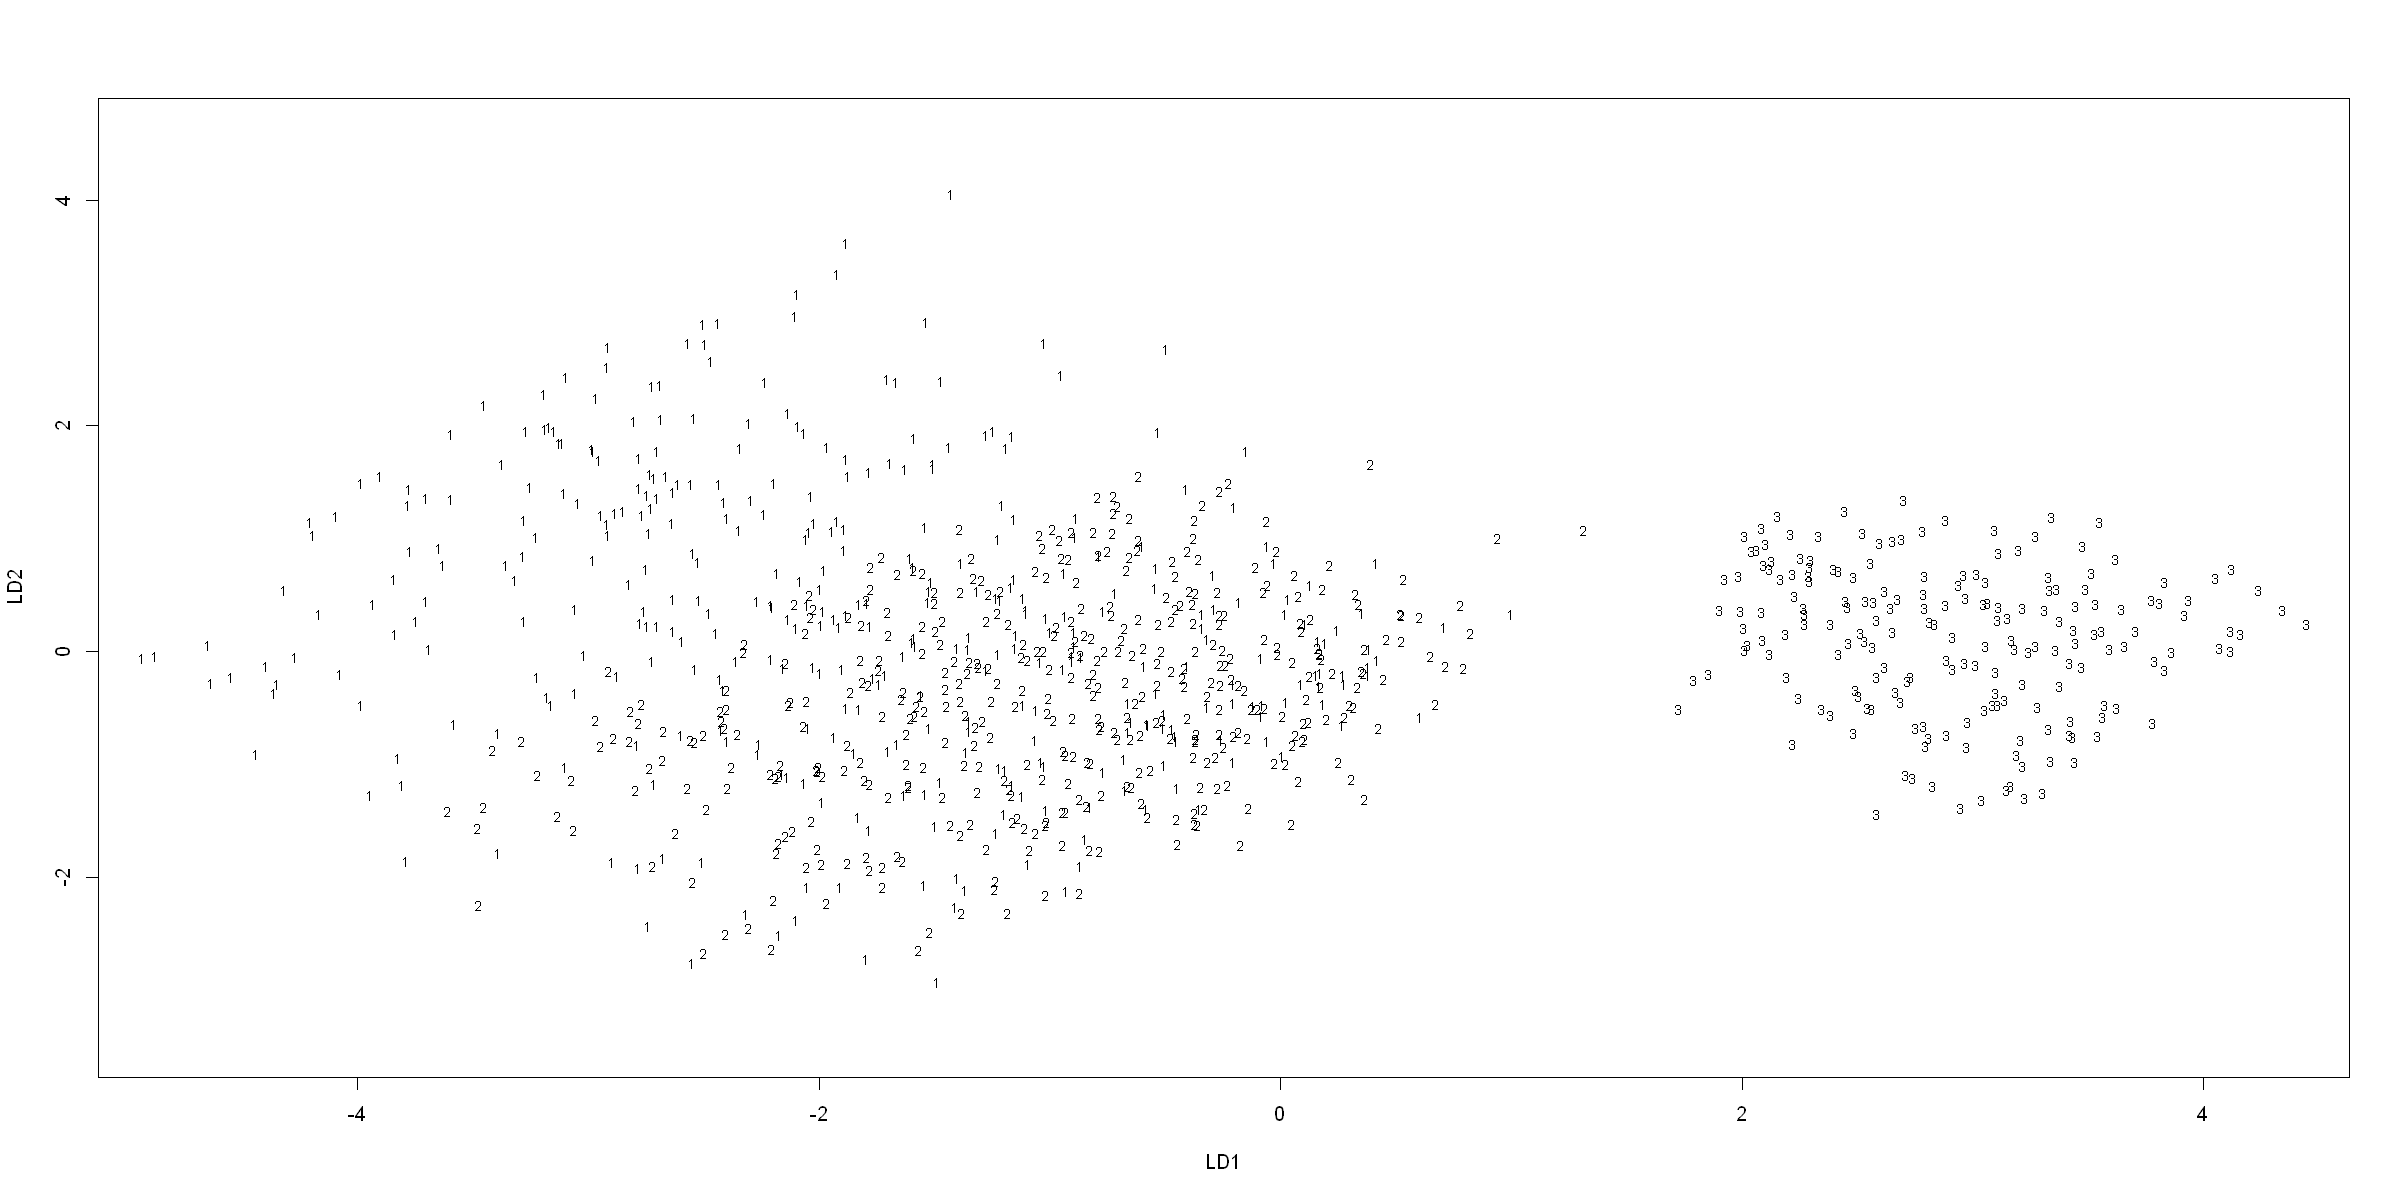

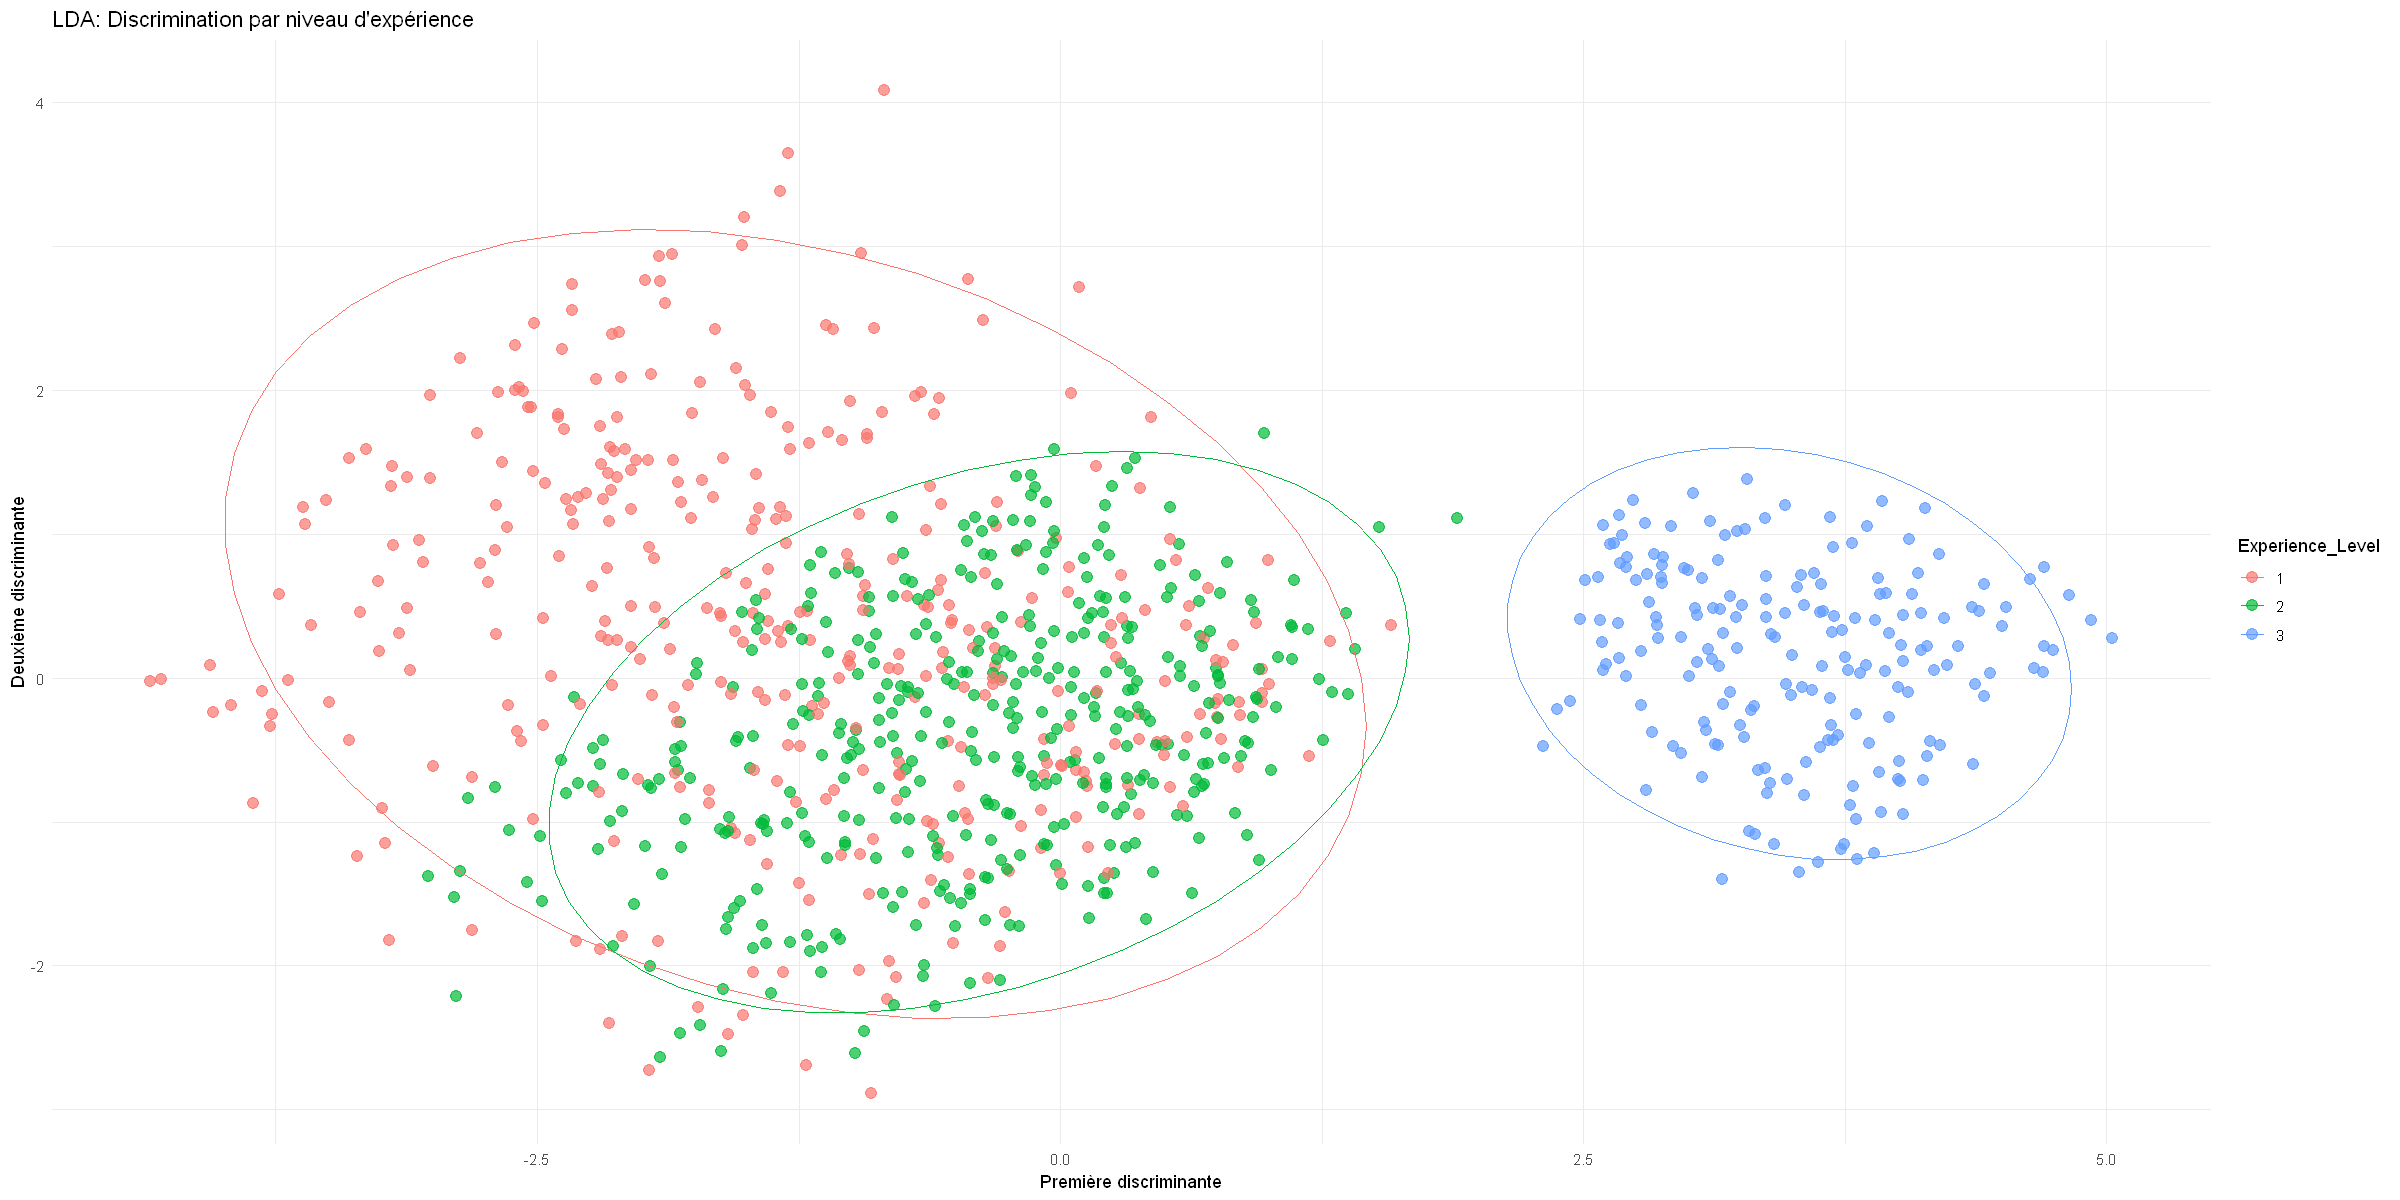

In [23]:
# Linear Discriminant Analysis
# Let's use Experience_Level as the target variable
library(MASS)

# Create a dataframe with the quantitative variables and the target variable
gym_lda_data <- cbind(gym_quanti, Experience_Level = gym$Experience_Level)

# Perform LDA
lda_result <- lda(Experience_Level ~ ., data = gym_lda_data)

# Summary of the LDA model
lda_result$scaling

# Plot the LDA results
plot_lda <- plot(lda_result)

# Create better visualization with ggplot2
lda_pred <- predict(lda_result, gym_lda_data)
lda_df <- data.frame(
    LD1 = lda_pred$x[,1],
    LD2 = lda_pred$x[,2],
    Experience_Level = gym_lda_data$Experience_Level
)

# Visualize the LDA results
ggplot(lda_df, aes(x = LD1, y = LD2, color = Experience_Level)) +
    geom_point(size = 3, alpha = 0.7) +
    stat_ellipse() +
    labs(title = "LDA: Discrimination par niveau d'expérience",
             x = "Première discriminante",
             y = "Deuxième discriminante") +
    theme_minimal()


### Interpretation des résultats de la LDA sur Experience level: 
On observe du graphe que la LDA permet bien de séparer es Experts (3) sur l’axe LD1, car ils sont clairement décalés.
Mais elle a plus de mal entre Débutants (1) et Intermédiaires (2), qui se mélangent beaucoup.
LD1 (axe horizontal - Première discriminante) :

- C’est l’axe principal de séparation.
Variables qui contribuent le plus à LD1 :

    Session_Duration (7.6756) : plus la durée d'entraînement est grande, plus ça tire vers la droite (plutôt vers les Experts).
    BMI (1.1431) : idem, un IMC plus élevé pousse vers des valeurs positives de LD1.
    Weight (-1.6378) : plus le poids est faible, plus LD1 augmente (moins de poids → potentiellement plus expérimenté ?).

- Interprétation :
Les Experts sont plutôt des personnes :

    Qui font des séances plus longues.
    Qui ont un IMC plus élevé.
    Et qui sont peut-être plus “légers” (au sens du poids, vu le signe négatif, mais à vérifier avec les données).

LD2 (axe vertical - Deuxième discriminante) :

- C’est l’axe secondaire, qui affine la séparation (notamment entre classes 1 et 2). Variables qui contribuent le plus à LD2 :

    Height (24.2335) : plus on est grand, plus on monte sur LD2.
    BMI (21.4079) : encore important ici.
    Weight (-22.3051) : plus le poids est faible, plus on monte sur LD2.

- Interprétation :
LD2 semble capturer des différences morphologiques (taille/poids/IMC), qui aident surtout à distinguer les individus entre Débutants et Intermédiaires, mais cette distinction reste difficile vu le chevauchement.